In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os

2023-11-22 14:57:26.597731: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model_name = 'enformer'
data_dir = '../data/'
test_results = f'../results/distance_test/{model_name}/'

In [3]:
tile_coords = pd.read_csv(f'../results/sufficiency_test/{model_name}/tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values
cre_tiles_starts_abs = np.abs(cre_tiles_starts - tss_tile[0]) // 1000

In [27]:
cre_df = pd.read_csv(f'../results/sufficiency_test/{model_name}_selected_cres.csv')


In [29]:
cre_df.groupby(['cell_line', 'context', 'tile class']).count()['seq_id']

cell_line  context    tile class
GM12878    enhancing  Enhancer       46
           neutral    Enhancer       33
                      Silencer       22
           silencing  Enhancer       48
                      Silencer      108
K562       enhancing  Enhancer       77
           neutral    Enhancer      145
                      Silencer       80
           silencing  Enhancer      537
                      Silencer      514
PC-3       enhancing  Enhancer       36
           neutral    Enhancer       20
                      Silencer       11
           silencing  Enhancer       42
                      Silencer       81
Name: seq_id, dtype: int64

In [30]:
cre_df['tile start relative to tss'] =  np.abs(cre_df['tile_start'] - tss_tile[0]) // 1000


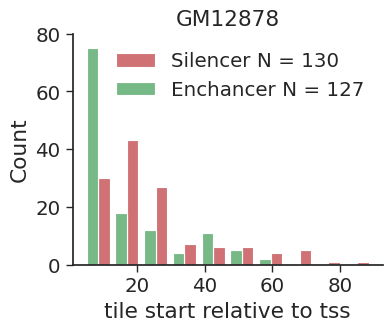

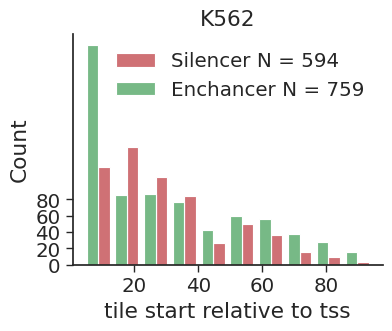

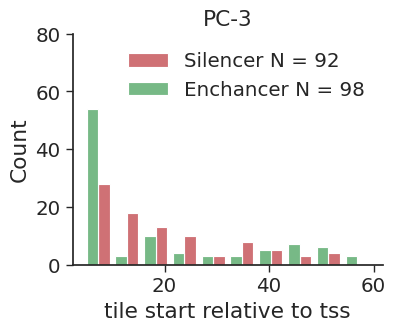

In [31]:

sns.set(font_scale = 1.3)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
color_map = {'Silencer': 'r', 'Enhancer': 'g'}
for cell, df in cre_df.groupby('cell_line'):
    fig, ax = plt.subplots(1, 1, figsize=[4,3])
    N = ({r[0]: r[1] for _,r in df.groupby('tile class').count().iloc[:,1].reset_index().iterrows()})
    sns.histplot(data=df, x='tile start relative to tss', hue='tile class', multiple="dodge", shrink=.8, ax=ax,bins=10, palette=color_map, alpha=0.8)
    ax.set_yticks([0, 20, 40, 60, 80])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend([f'Silencer N = {N["Silencer"]}', f'Enchancer N = {N["Enhancer"]}'], frameon=False)
    plt.title(cell)
    plt.show()

In [32]:
track_index = [4824, 5110, 5111]
target_df = pd.read_csv(f'{data_dir}/{model_name}_targets_human.txt', sep='\t')
cell_lines = [utils.clean_cell_name(target_df.iloc[t]['description']) for t in track_index]
cell_lines

['PC-3', 'GM12878', 'K562']

In [174]:
result_normalized_effects = []
all_norm_effects = []
raw_preds = {}
for i, cell_line in enumerate(cell_lines):
    raw_preds[cell_line] = []
    cre_df_cell = cre_df[cre_df['cell_line'] == cell_line]
    cre_df_cell.insert(1, "distance to TSS (Kb)", [np.abs(int(i) - tss_tile[0]) // 1000 for i in cre_df_cell['tile_start'].values ])
    for j, (_, row) in tqdm(enumerate(cre_df_cell.iterrows())):
        tile_start, tile_end = [row['tile_start'], row['tile_end']]
        result_path = f'{test_results}/{row["seq_id"]}_{tile_start}_{tile_end}.pickle'
        res = utils.read_pickle(result_path)
        control = res['mean_control'][447:449,i].mean()
        test = res['mean_mut'][:, 447:449, i].mean(axis=-1)
        # norm_effects = test / control
        norm_effects = test / np.max(test)
        all_norm_effects.append(norm_effects)
        df = pd.DataFrame([norm_effects, cre_tiles_starts_abs]).T
        df.columns = ['Fold change over control', 'Binned distance (Kb)']
        df['Normalized CRE effect (control)'] = row['Normalized CRE effect']
        raw_preds[cell_line].append(test)
        df['cell line'] = cell_line
        df['context'] = row['context']
        df['tile class'] = row['tile class']
        result_normalized_effects.append(df)
result_normalized_effects = pd.concat(result_normalized_effects)

190it [00:00, 265.29it/s]
257it [00:00, 830.84it/s]
1353it [00:01, 829.30it/s]


In [151]:
result_normalized_effects.head(2)


Fold change over control  Binned distance (Kb)   
0                  0.183777                  95.0  \
1                  0.136103                  90.0   

   Normalized CRE effect (control) cell line    context tile class  
0                         0.336298      PC-3  enhancing   Enhancer  
1                         0.336298      PC-3  enhancing   Enhancer

In [145]:
# my_palette = {}
# tile_labels = {}
# for i, row in n_df.iterrows():
#     c = 'g' if i=='Enhancer' else 'r'
#     my_palette[f'{i} N={row.iloc[0]}'] = c
#     k = 'Enhancer' if 'Enh' in k else 'Silencer'
#     tile_labels[k] = f'{i} N={row.iloc[0]}'

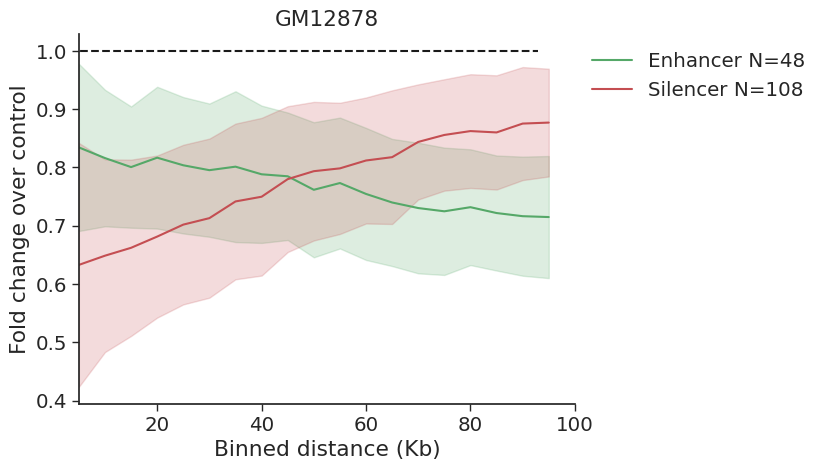

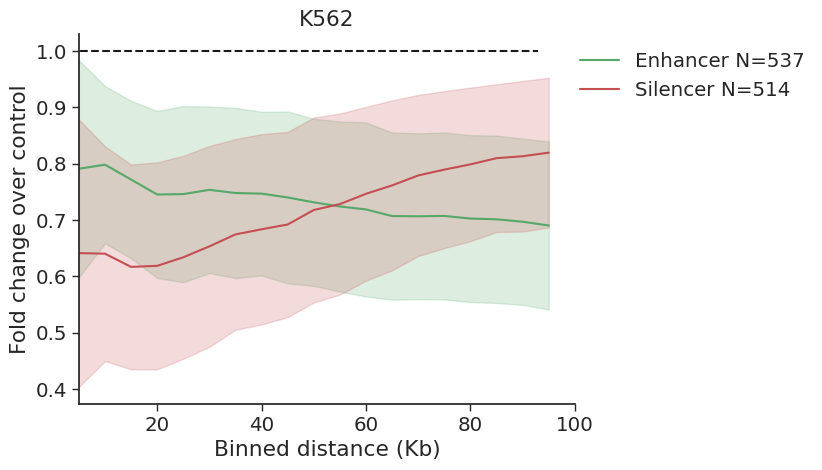

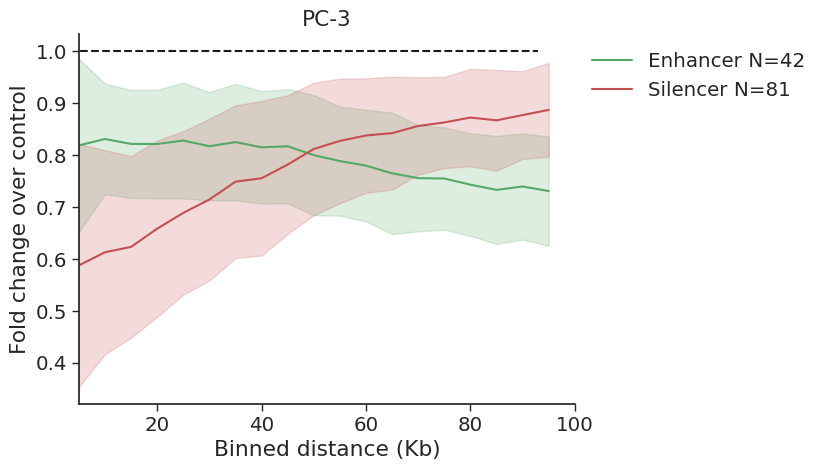

In [146]:
for cell_line, df in result_normalized_effects.groupby('cell line'):
    df = pd.concat([df[(df['context']=='silencing') & (df['tile class']=='Enhancer')],
                    df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
])
#     df = pd.concat([df[(df['context']=='enhancing') & (df['tile class']=='Enhancer')], df[(df['context']=='silencing') & (df['tile class']=='Silencer')]
# ])
    n_df = df.groupby(['tile class']).count()
    n_dict = dict(zip(list(n_df.index), n_df.iloc[:,-1]))
    my_palette = {}
    tile_labels = {}
    for i, row in n_df.iterrows():
        c = 'g' if i=='Enhancer' else 'r'
        my_palette[f'{i} N={row.iloc[0]//38}'] = c
        k = 'Enhancer' if 'Enh' in i else 'Silencer'
        tile_labels[k] = f'{i} N={row.iloc[0]//38}'
    df['tile class'] = [tile_labels[t] for t in df['tile class']]
    ax=sns.lineplot(data=df, x='Binned distance (Kb)', y='Fold change over control', hue='tile class', ci='sd',
              palette=my_palette)
    ax.plot([1,93],[1,1], '--k')
    ax.set_xlim([5,100])
    # ax.set_ylim(0,1.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)

    plt.legend(frameon=False, bbox_to_anchor=[1.5,1])
    plt.show()

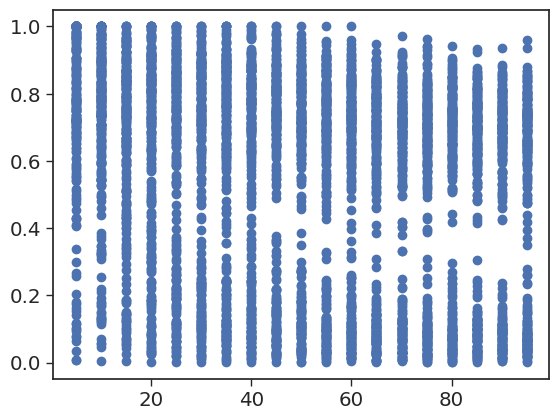

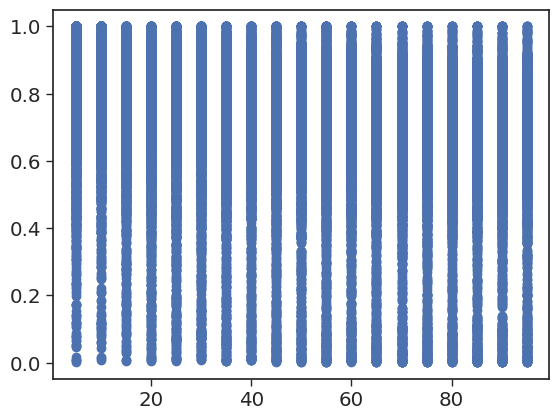

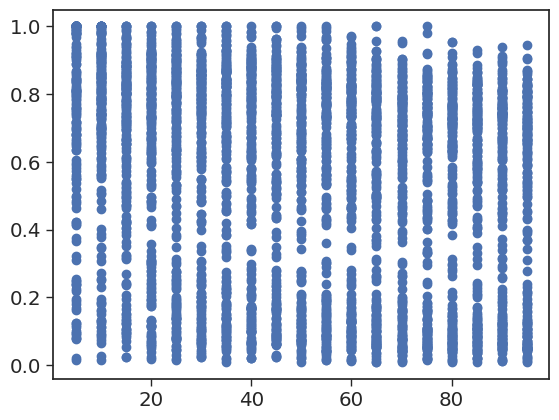

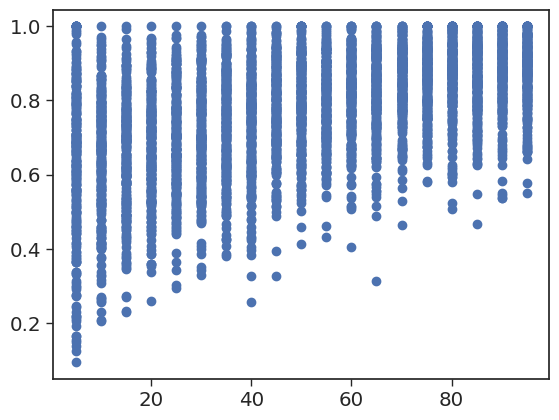

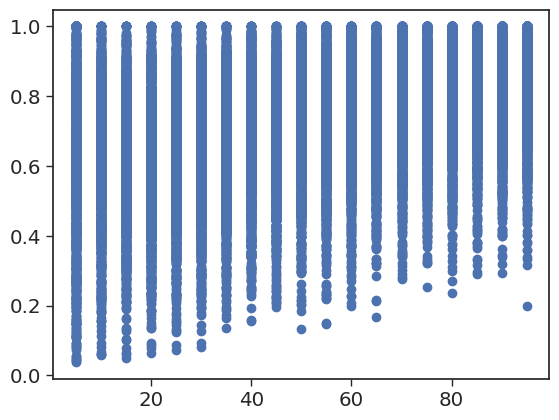

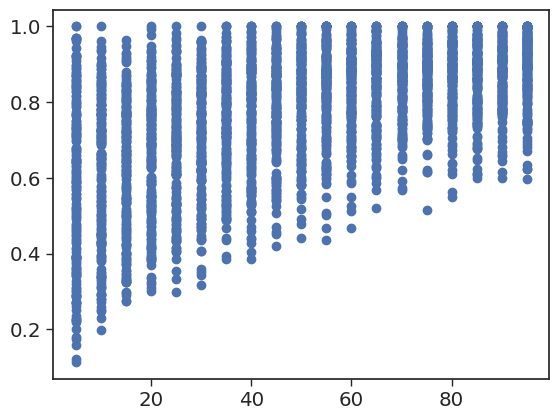

In [173]:
for (tile_class, cell_line), df in result_normalized_effects.groupby(['tile class', 'cell line']):
    plt.scatter(data=df, x='Binned distance (Kb)', y='Fold change over control')
    plt.show()

In [172]:
df

Fold change over control  Binned distance (Kb)   
0                   0.896411                  95.0  \
1                   0.878985                  90.0   
2                   0.913940                  85.0   
3                   0.870856                  80.0   
4                   1.000000                  75.0   
..                       ...                   ...   
33                  0.923143                  75.0   
34                  0.932640                  80.0   
35                  0.958351                  85.0   
36                  0.945288                  90.0   
37                  0.962506                  95.0   

    Normalized CRE effect (control) cell line    context tile class  
0                         -0.421978      PC-3    neutral   Silencer  
1                         -0.421978      PC-3    neutral   Silencer  
2                         -0.421978      PC-3    neutral   Silencer  
3                         -0.421978      PC-3    neutral   Silencer  
4                         -0.421978      PC-3    neutral   Silencer  
..                              ...       ...        ...        ...  
33                        -0.753557      PC-3  silencing   Silencer  
34                        -0.753557      PC-3  silencing   Silencer  
35                        -0.753557      PC-3  silencing   Silencer  
36                        -0.753557      PC-3  silencing   Silencer  
37                        -0.753557      PC-3  silencing   Silencer  

[3496 rows x 6 columns]

In [156]:
import umap
from sklearn.preprocessing import StandardScaler

In [154]:
reducer = umap.UMAP()

In [157]:
scaled_penguin_data = StandardScaler().fit_transform(raw_preds['PC-3'])

In [167]:
embedding = reducer.fit_transform(raw_preds['PC-3'])
embedding.shape

(190, 2)

In [168]:
len(raw_preds['PC-3'])

190

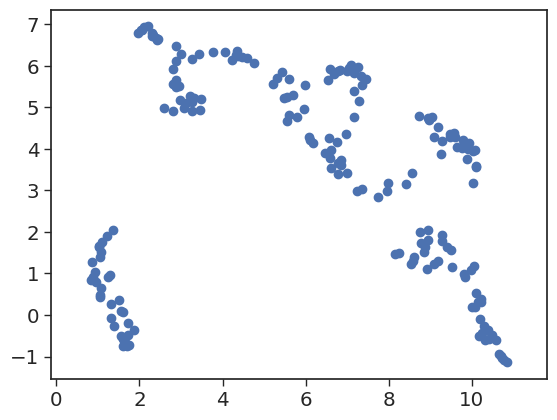

In [169]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')


In [163]:
np.argwhere(embedding[:, 0] < 0).flatten()

array([ 0,  1,  2,  3,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

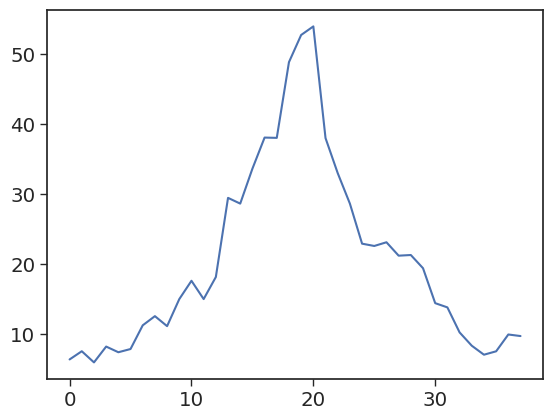

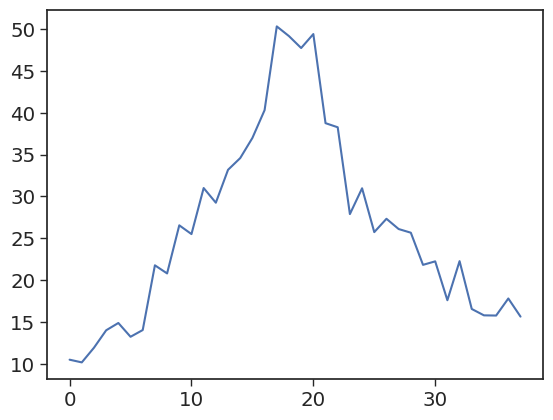

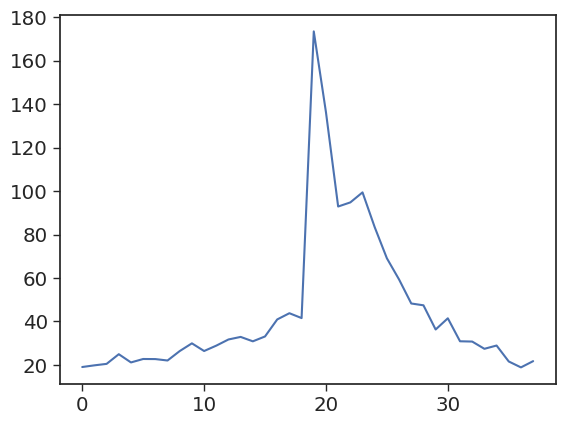

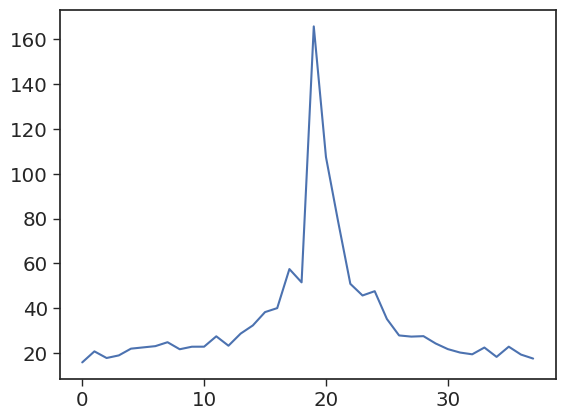

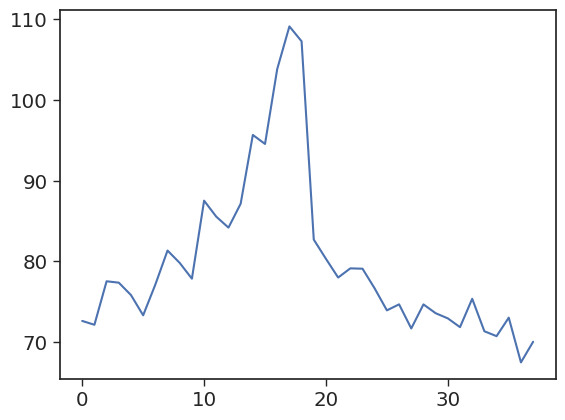

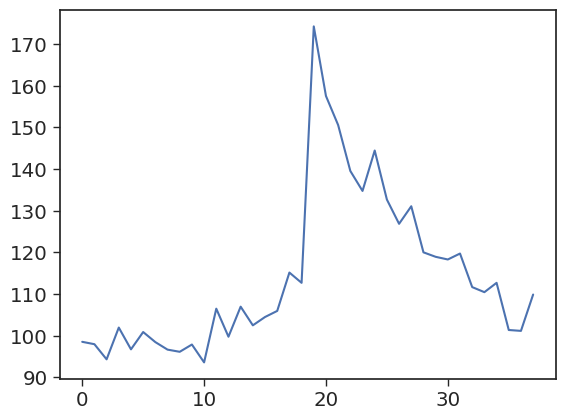

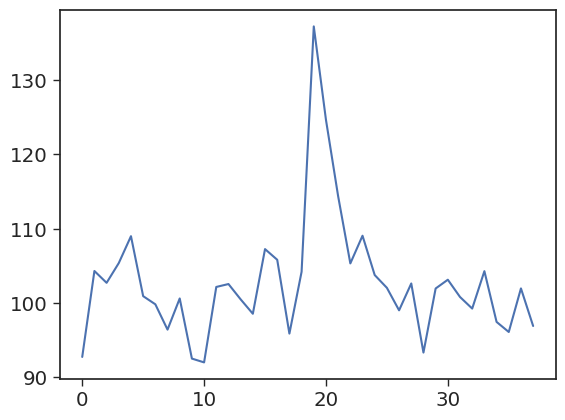

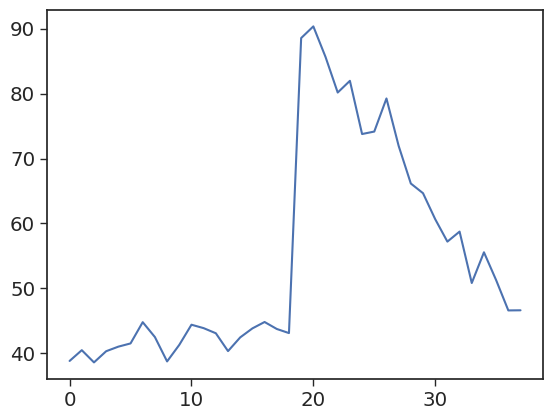

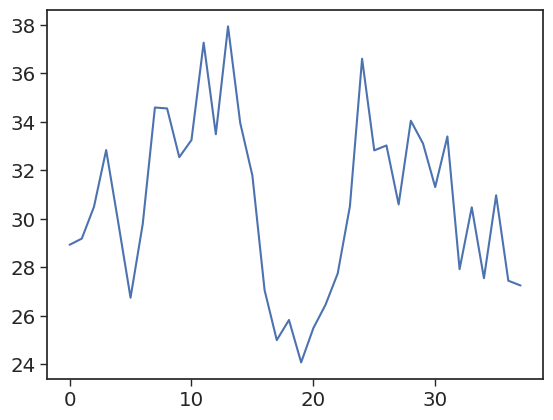

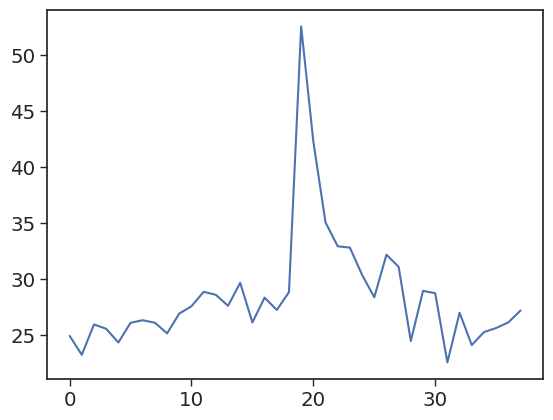

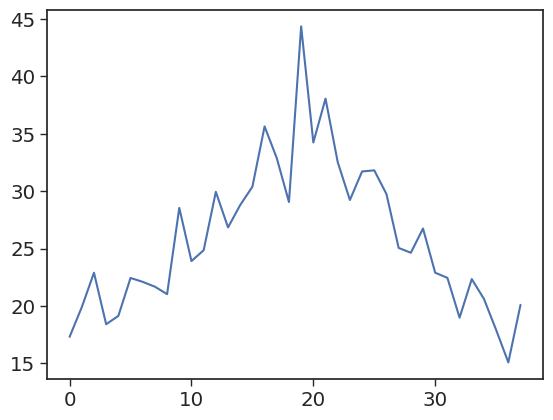

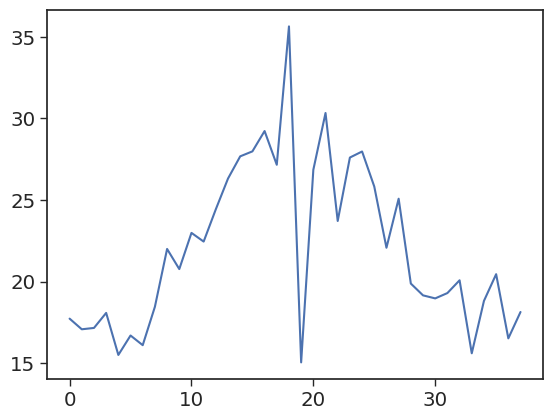

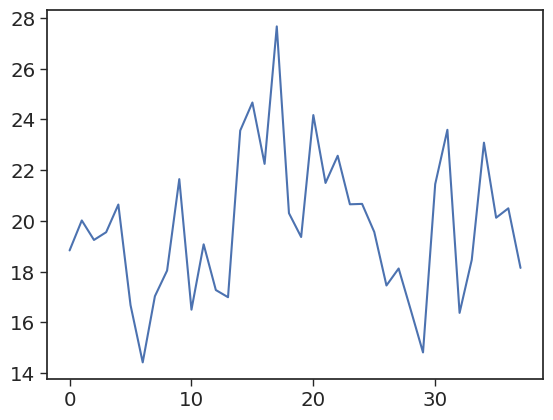

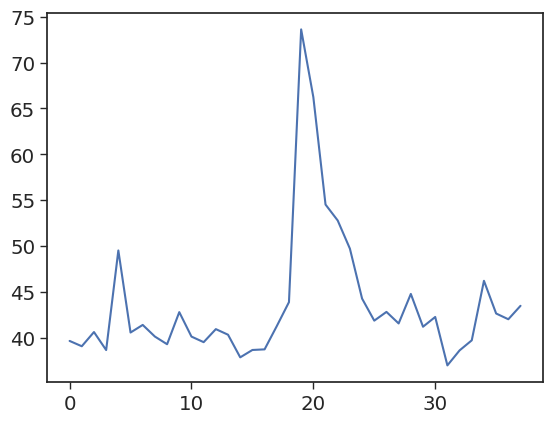

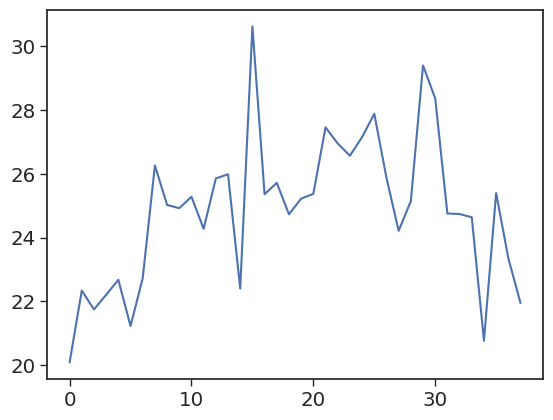

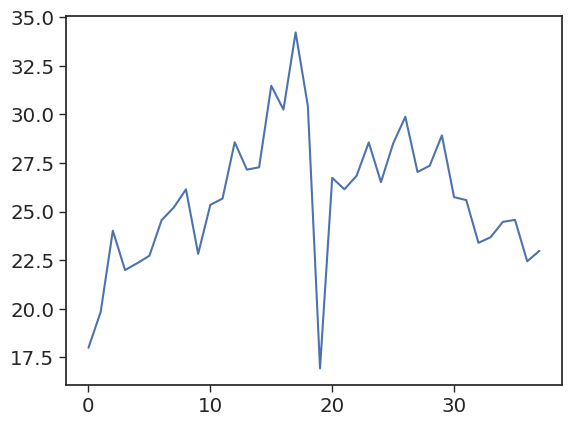

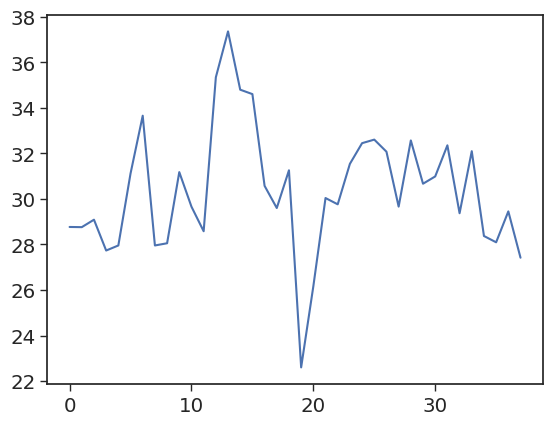

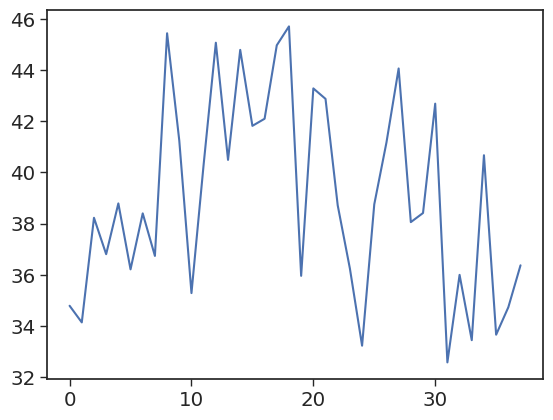

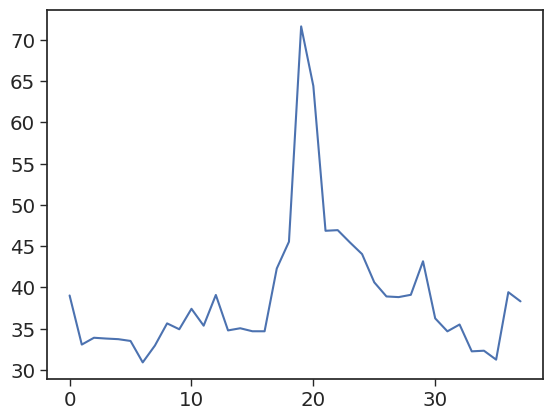

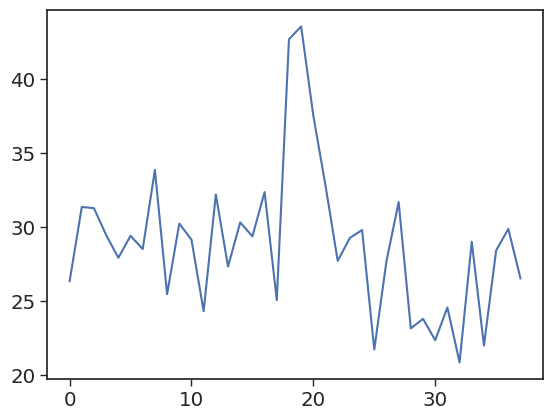

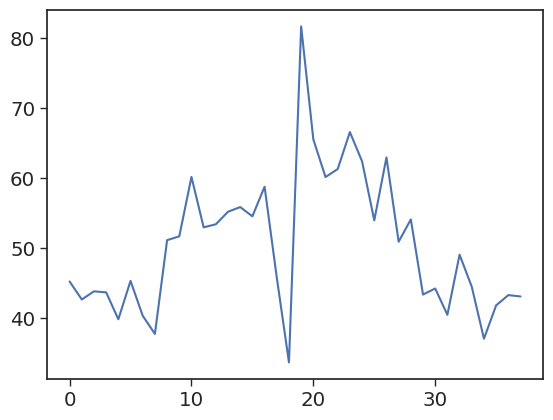

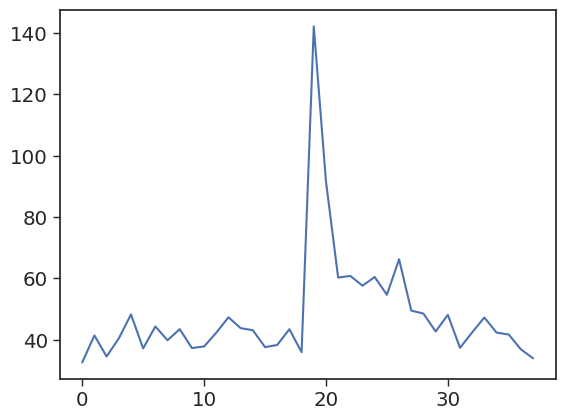

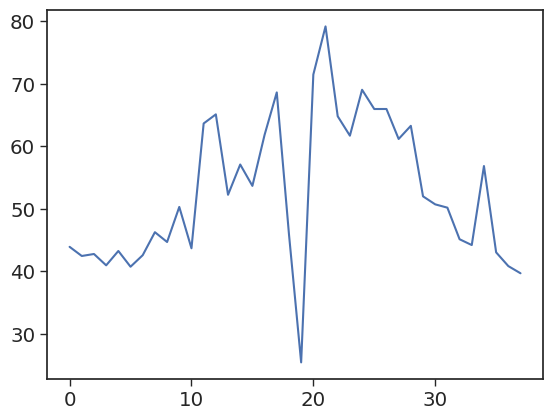

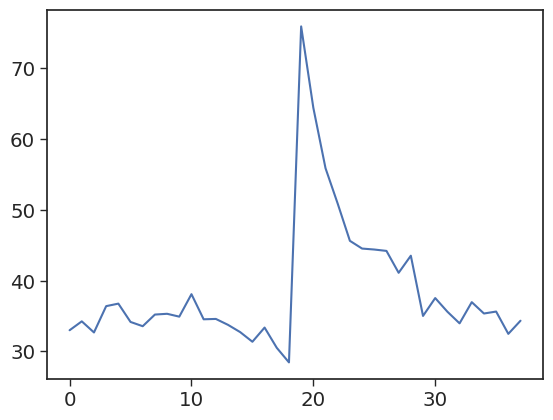

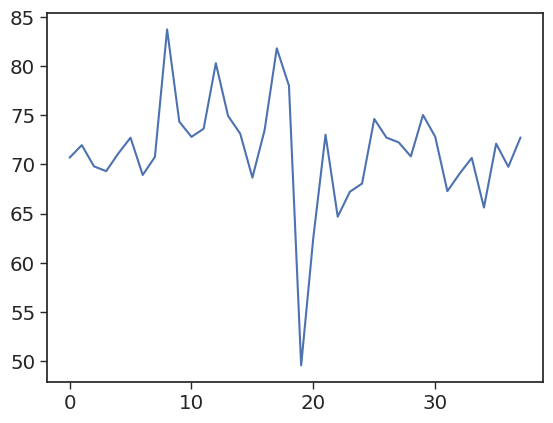

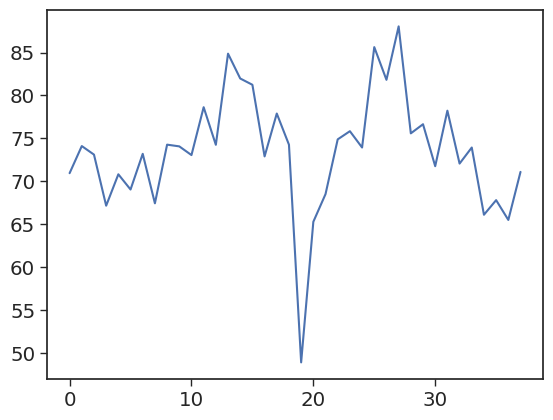

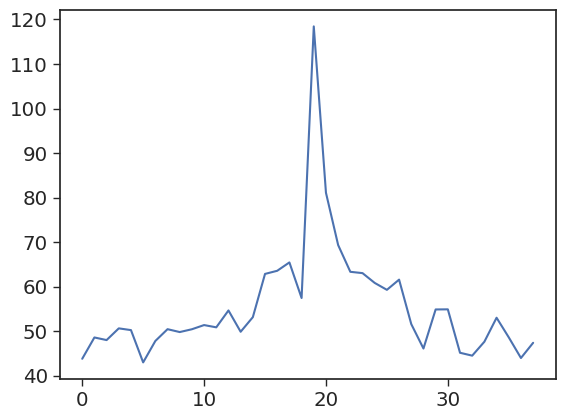

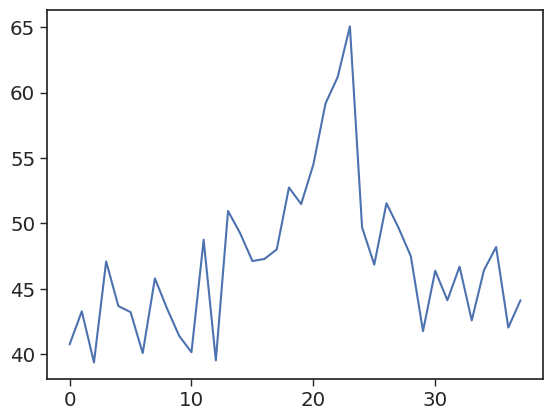

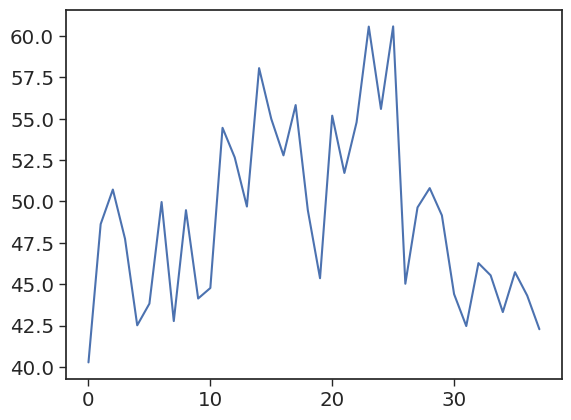

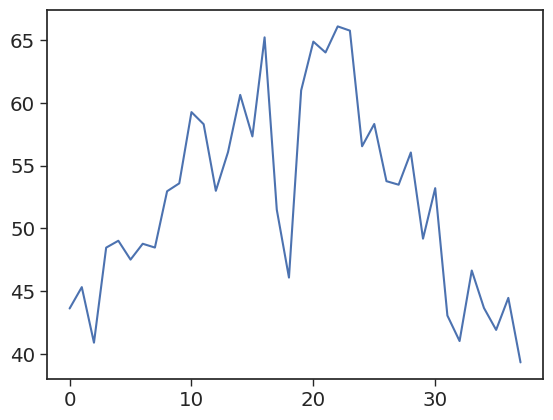

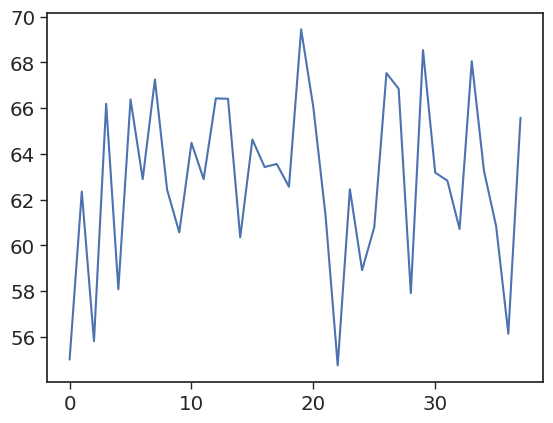

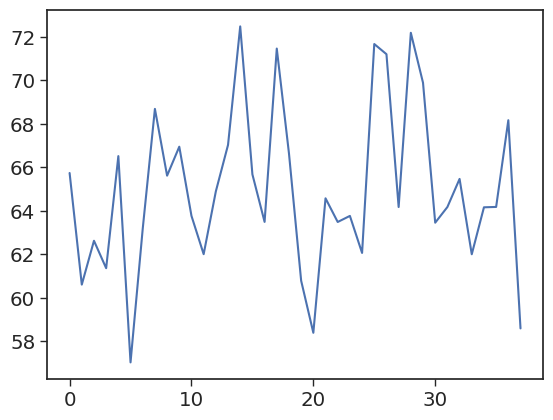

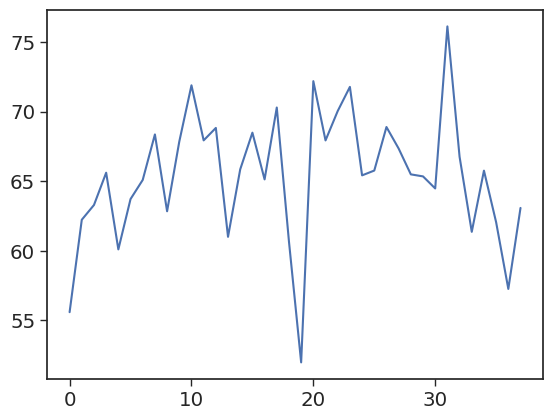

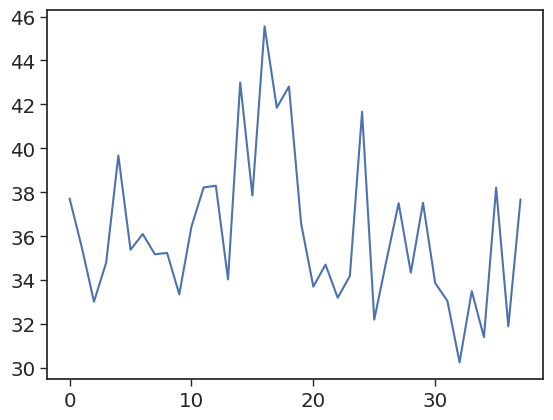

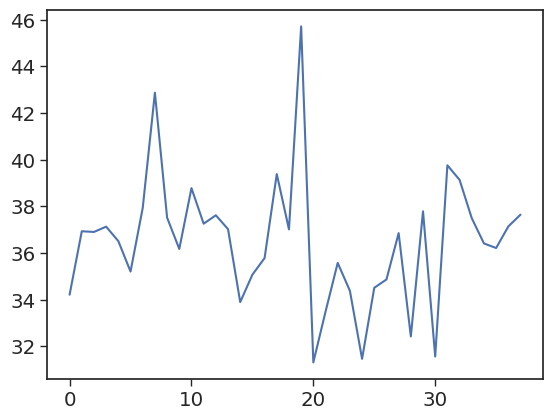

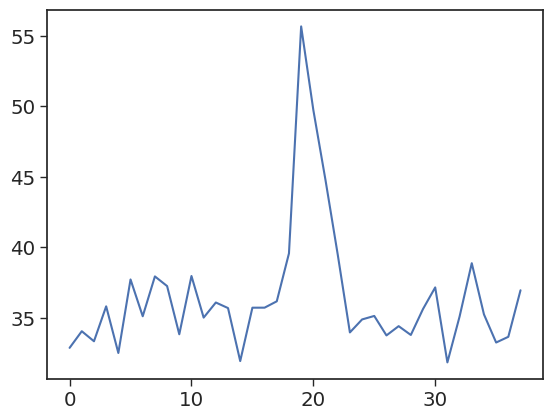

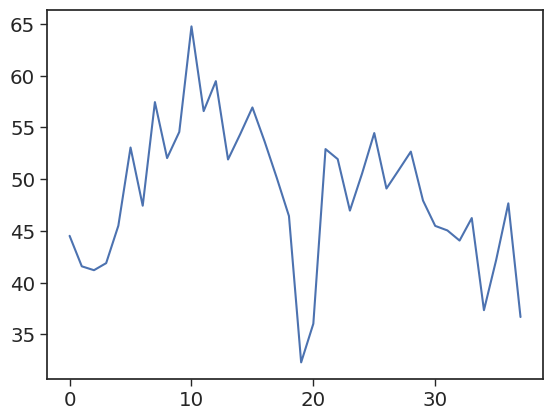

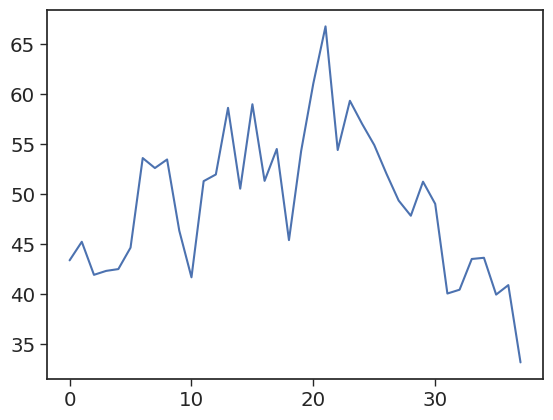

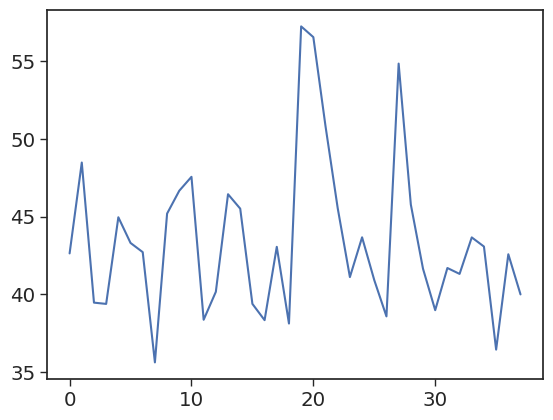

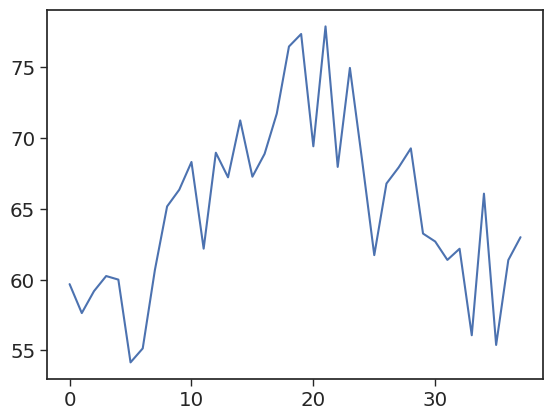

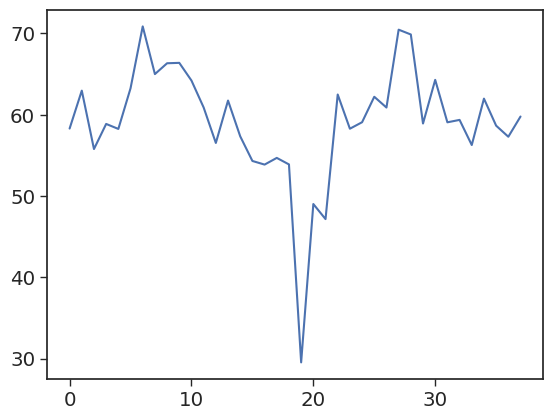

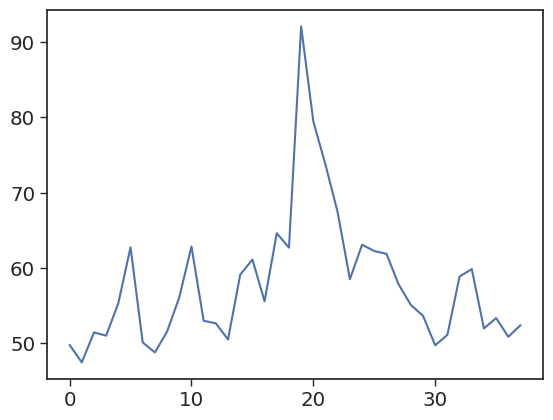

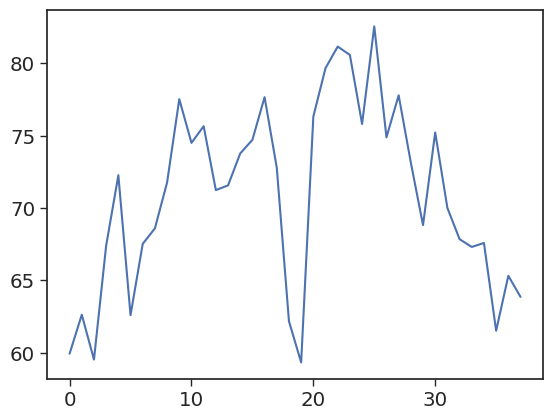

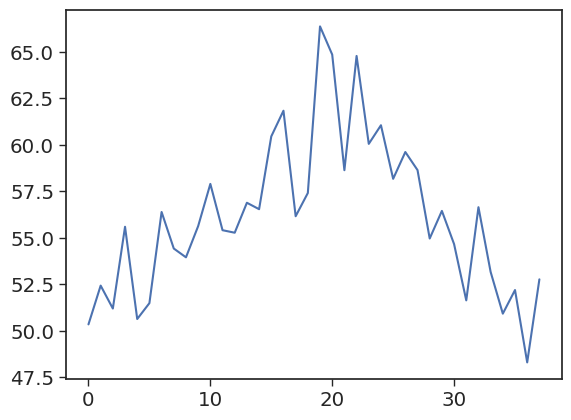

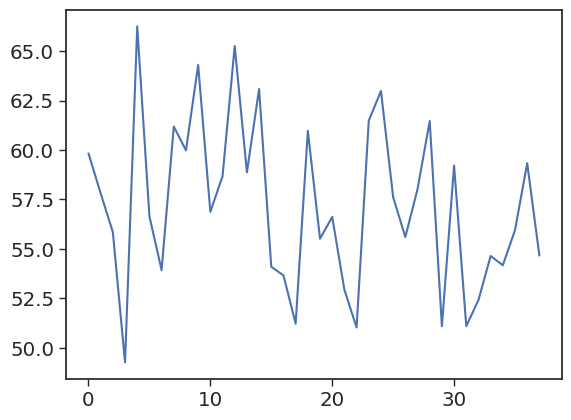

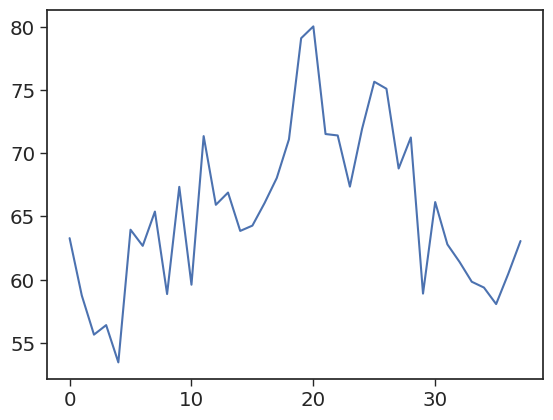

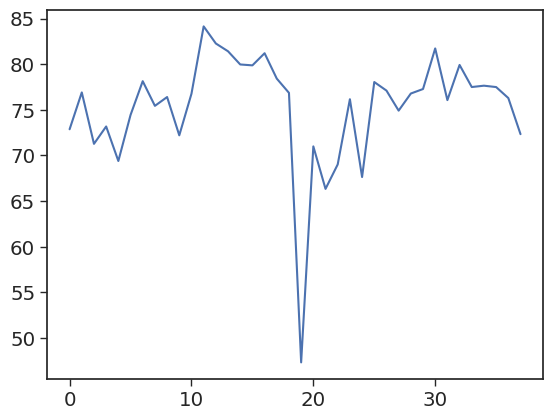

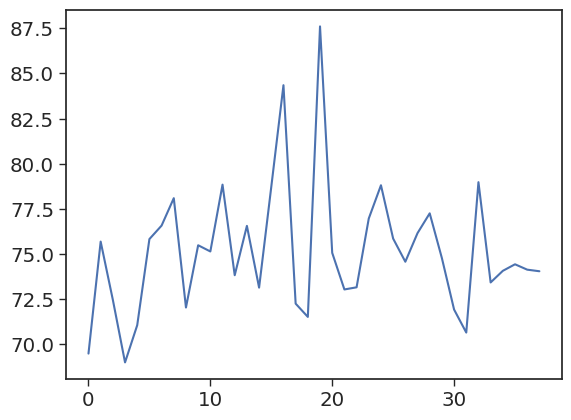

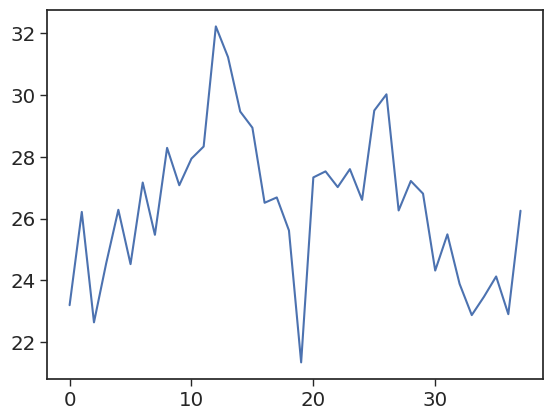

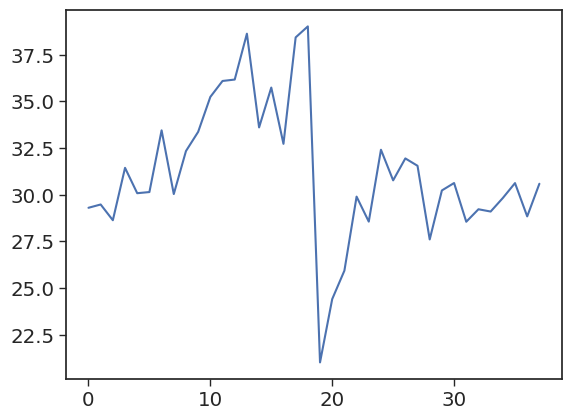

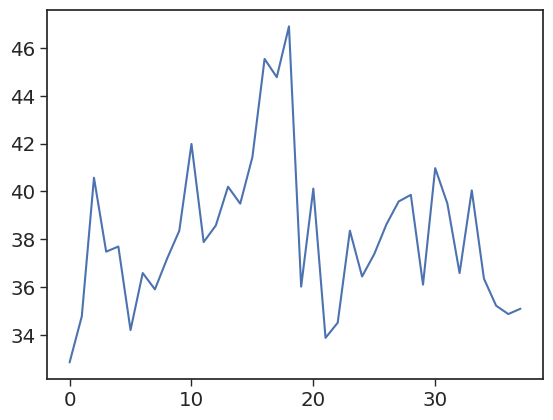

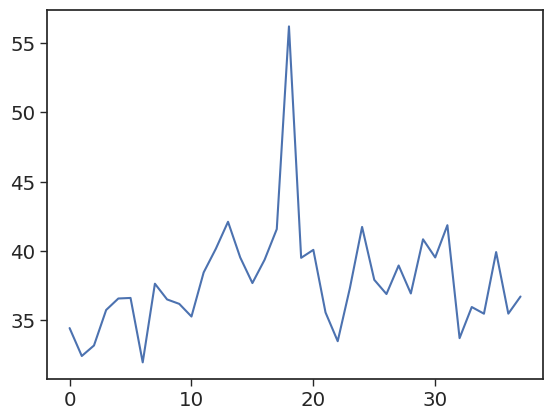

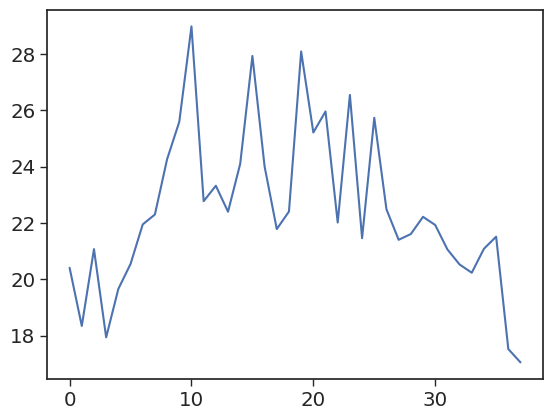

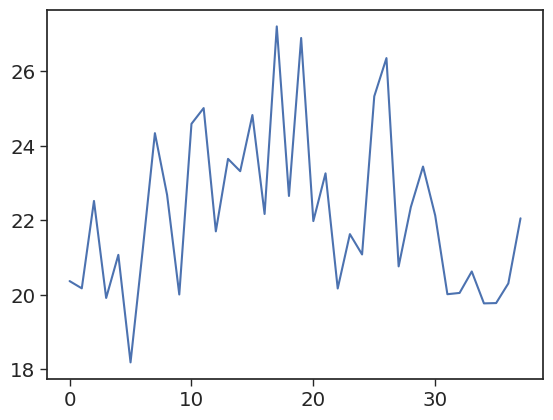

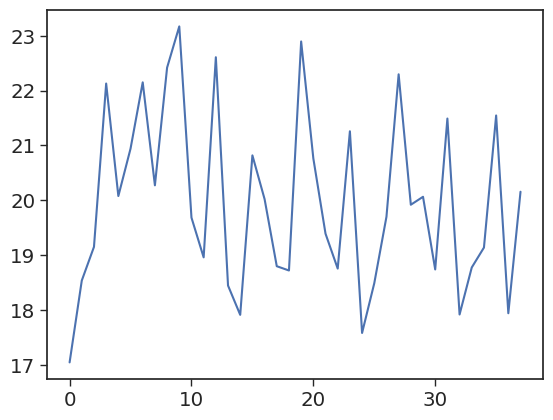

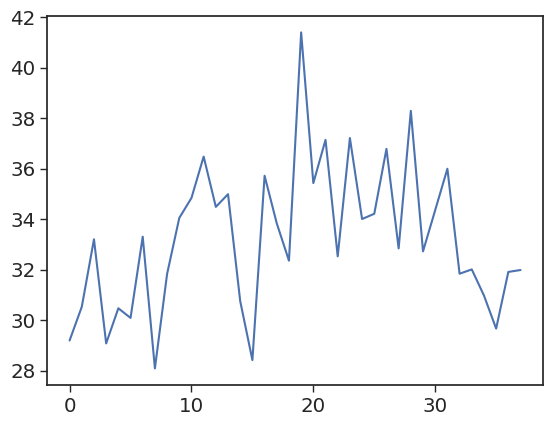

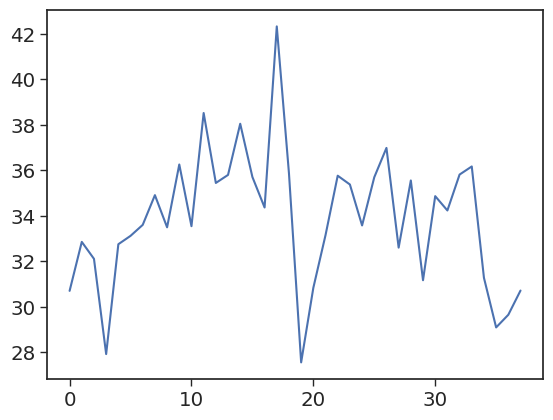

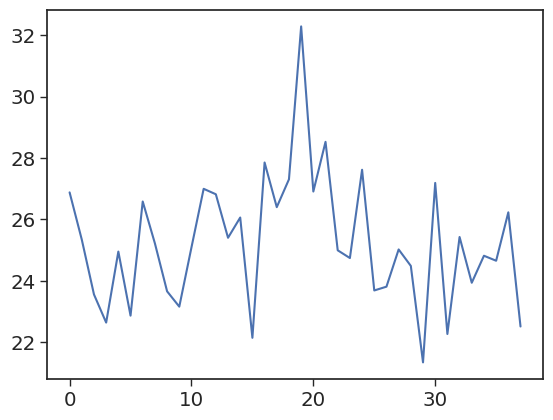

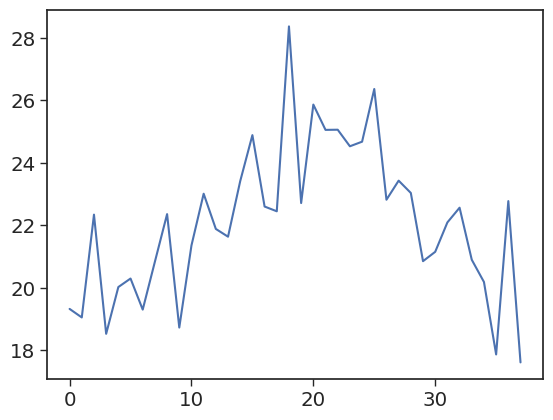

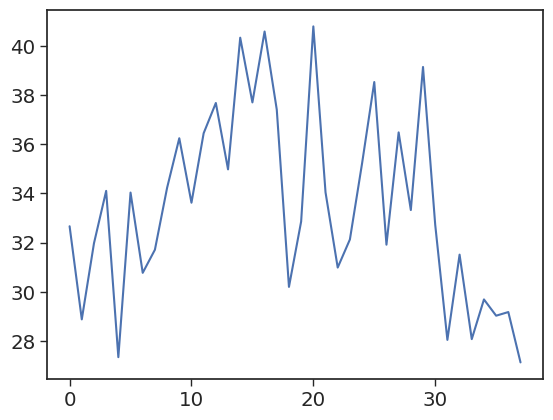

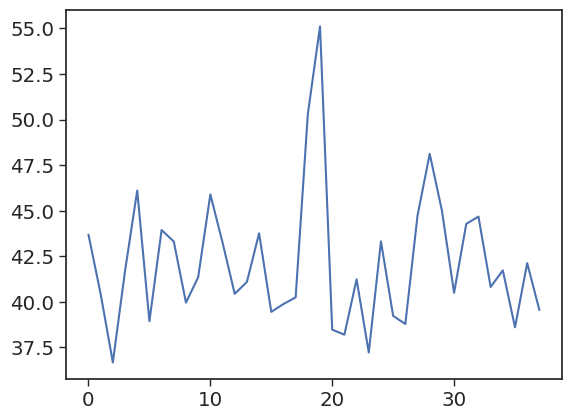

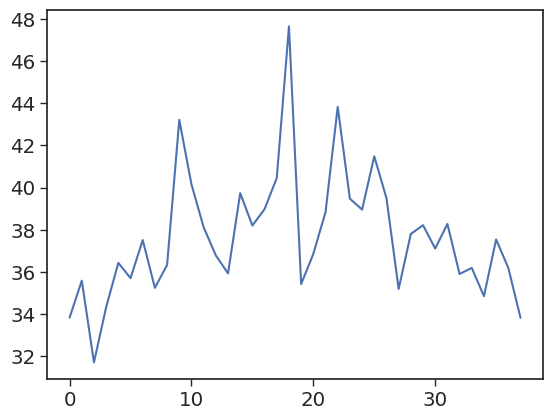

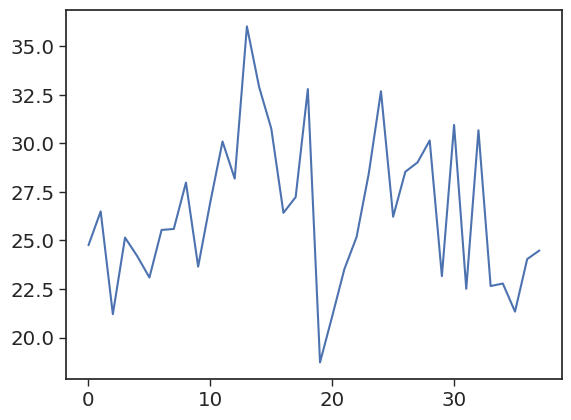

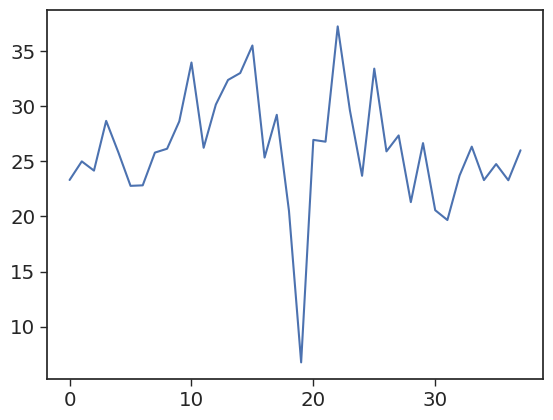

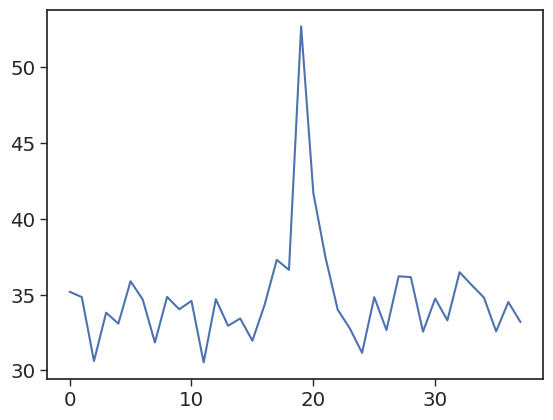

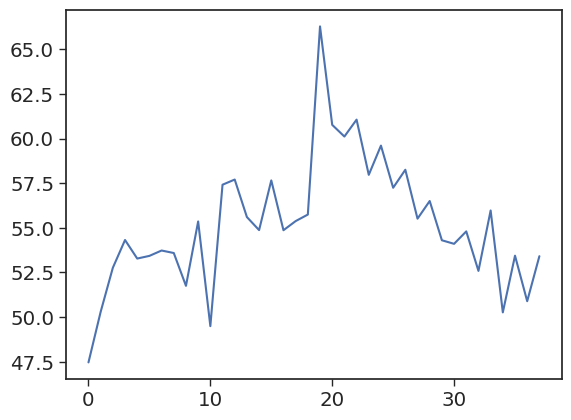

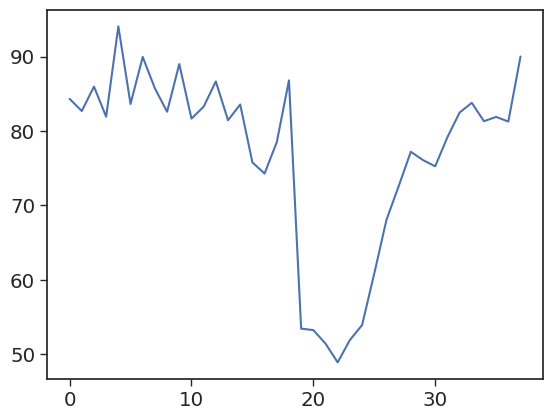

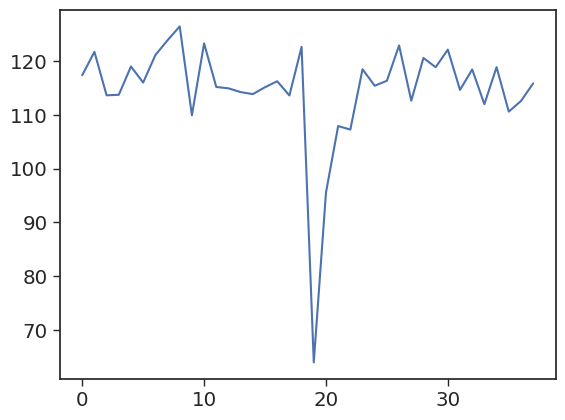

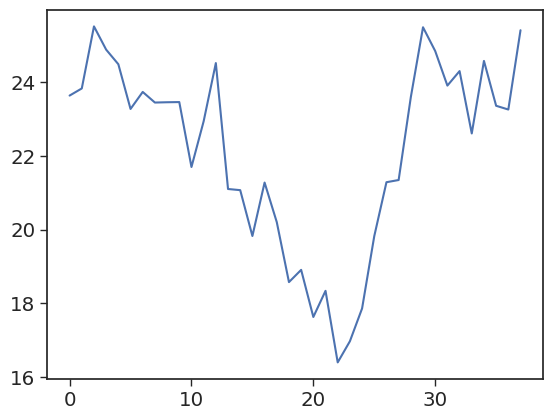

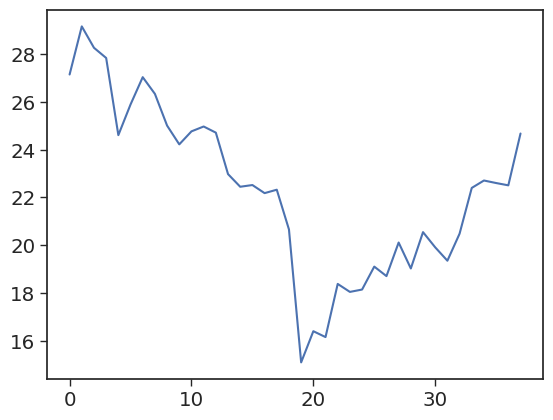

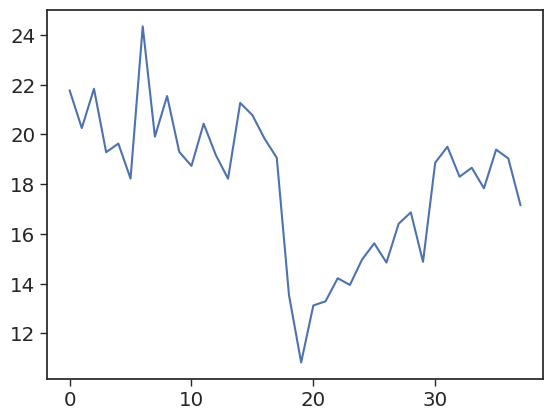

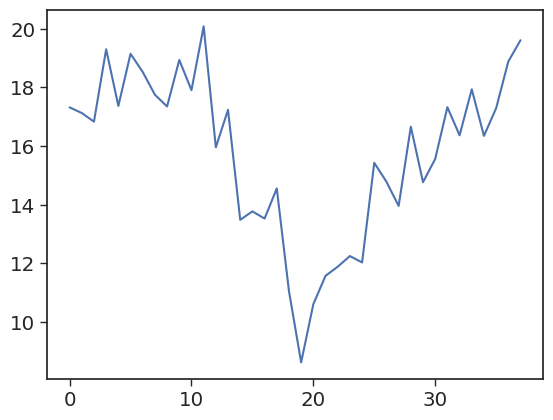

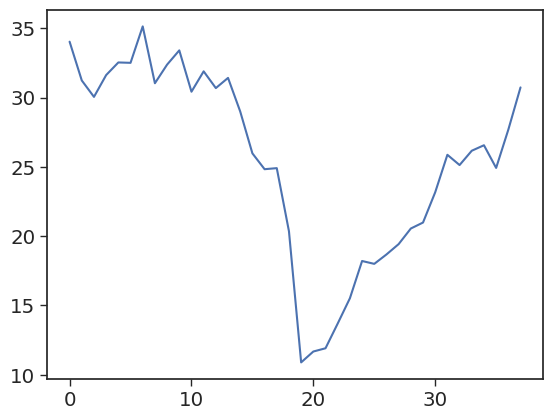

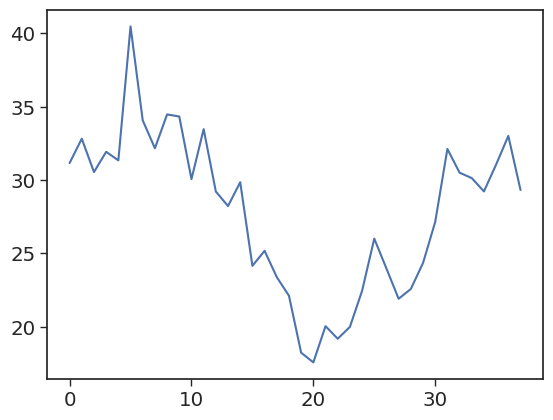

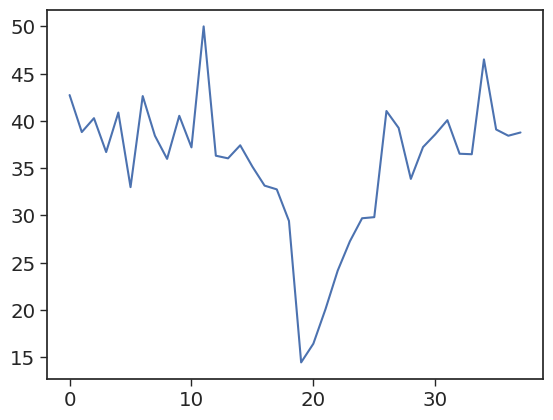

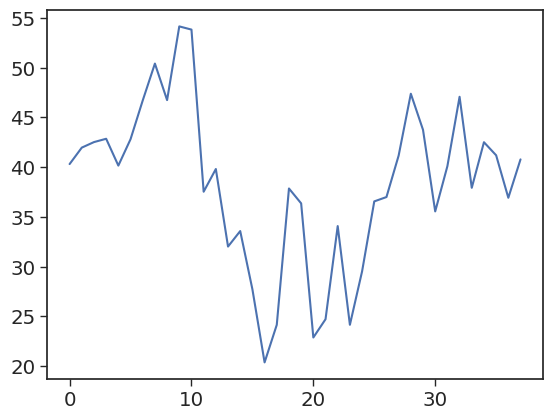

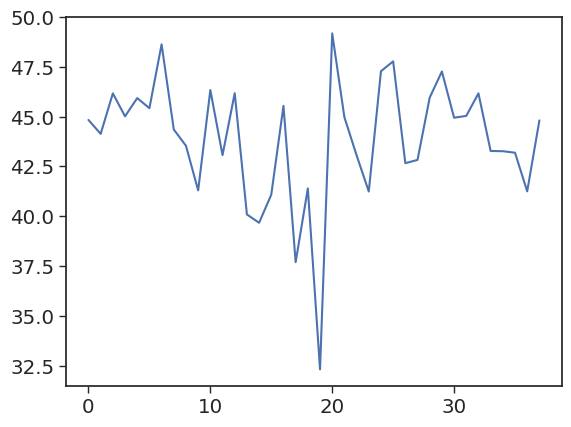

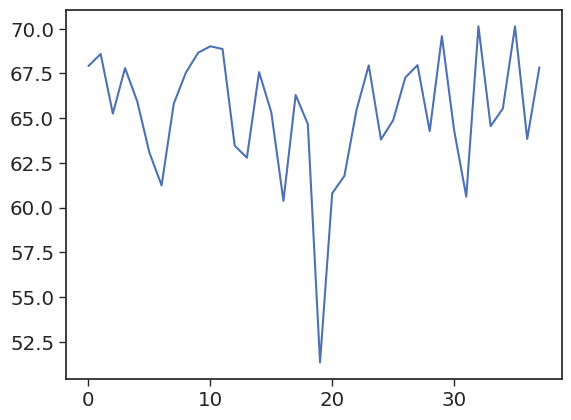

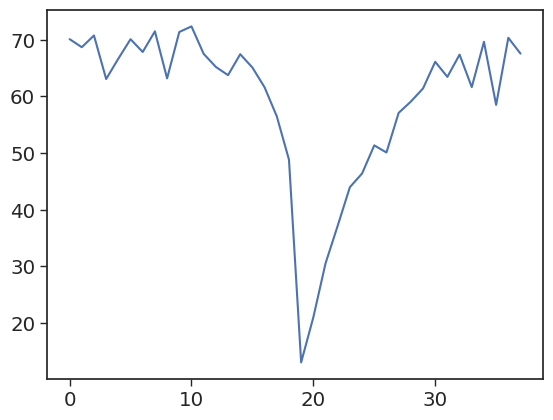

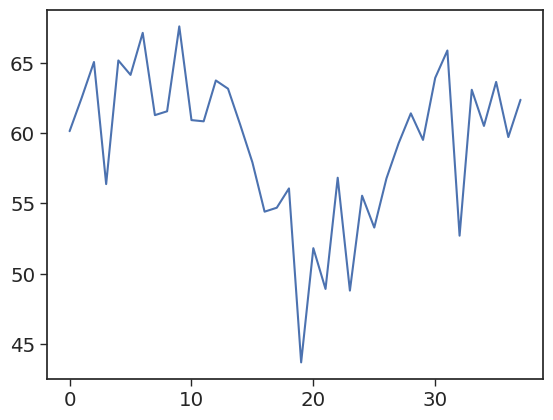

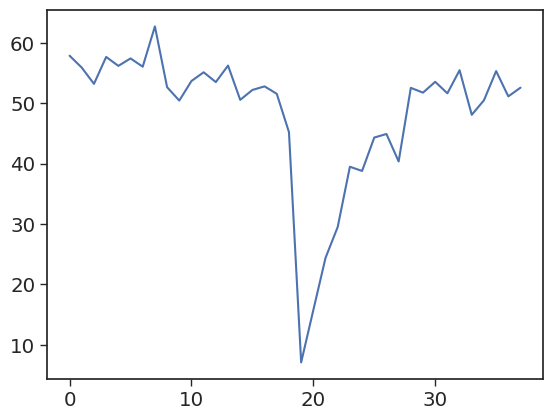

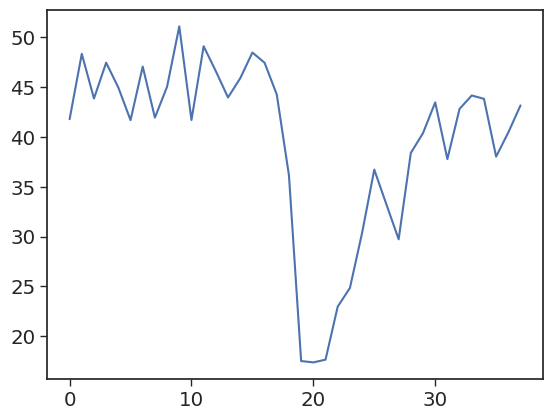

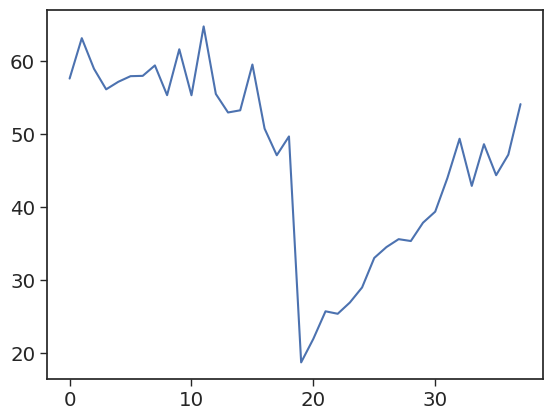

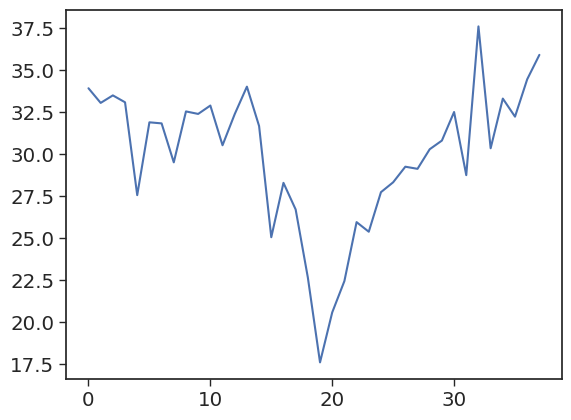

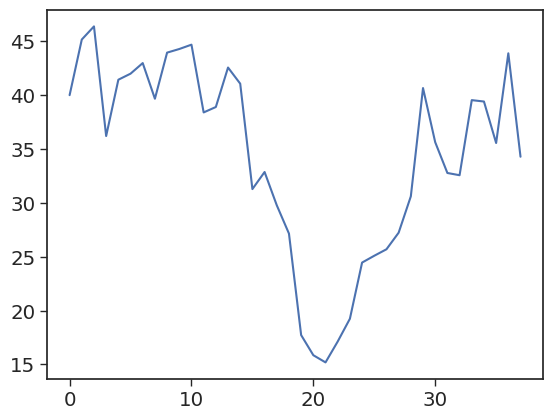

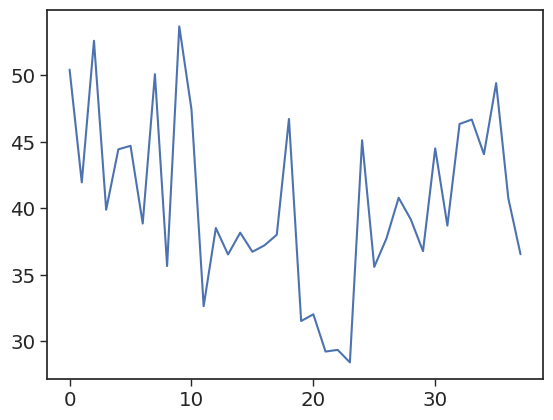

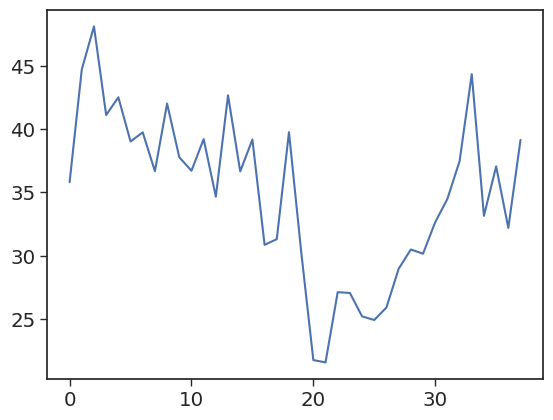

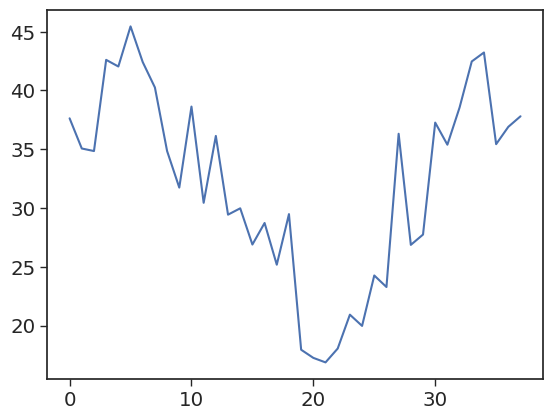

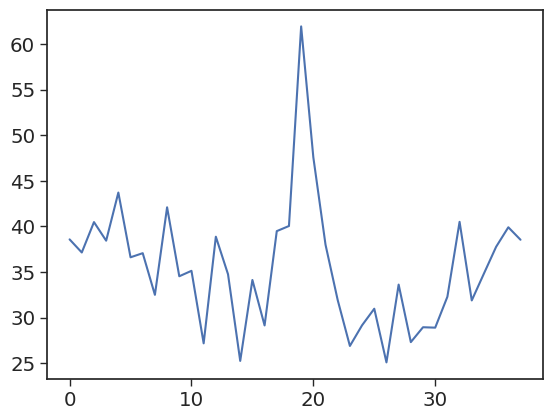

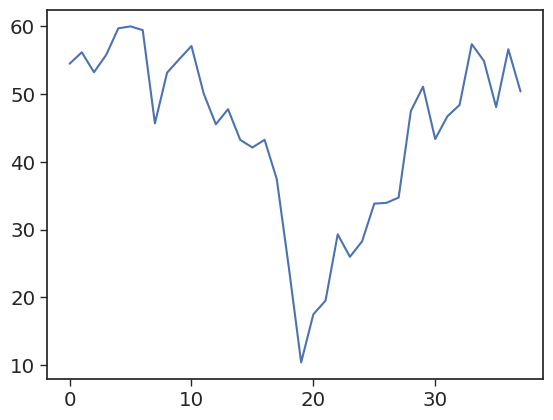

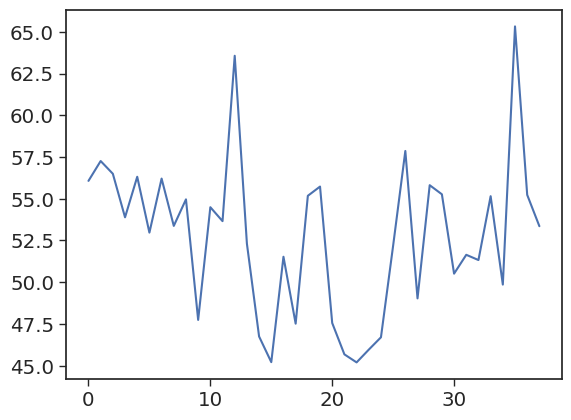

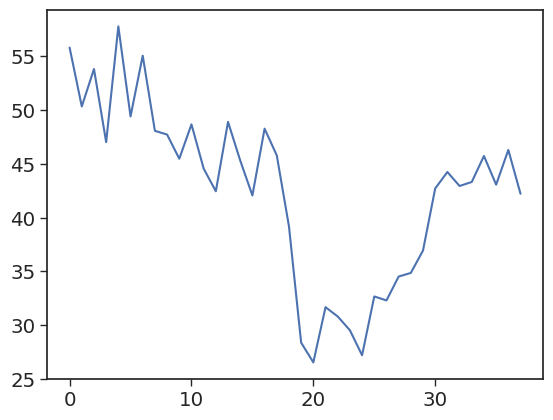

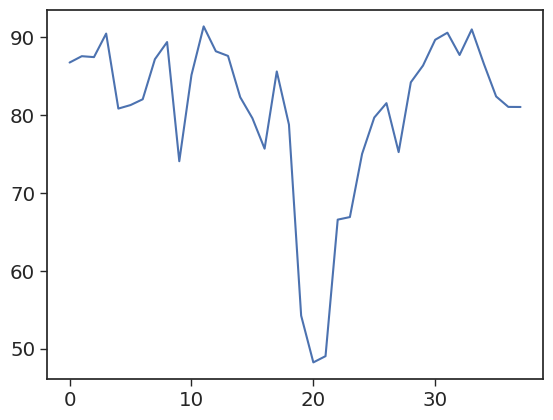

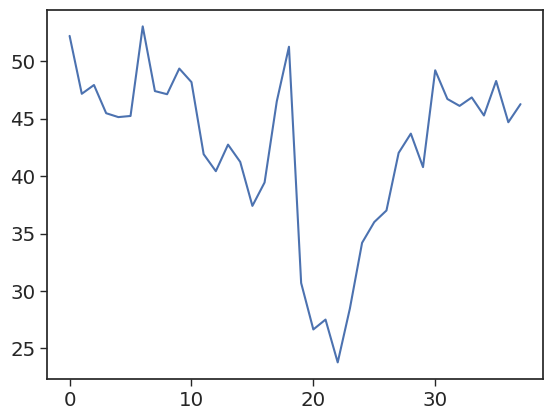

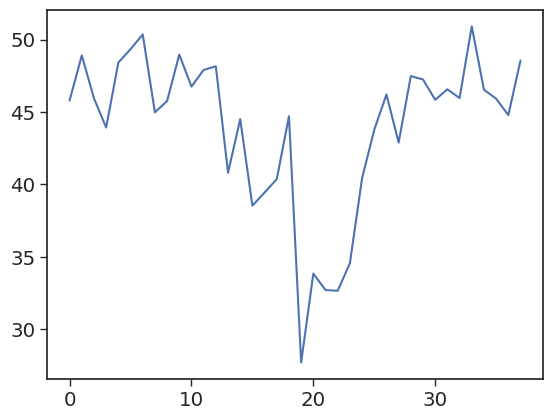

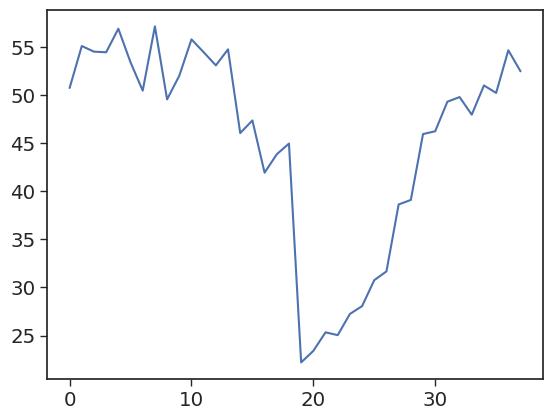

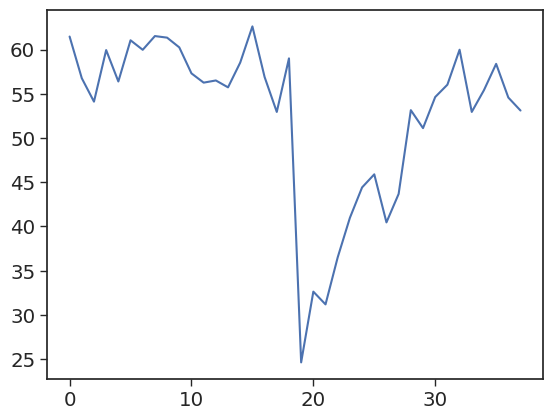

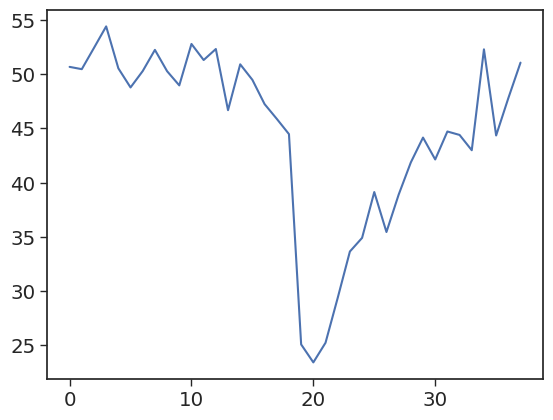

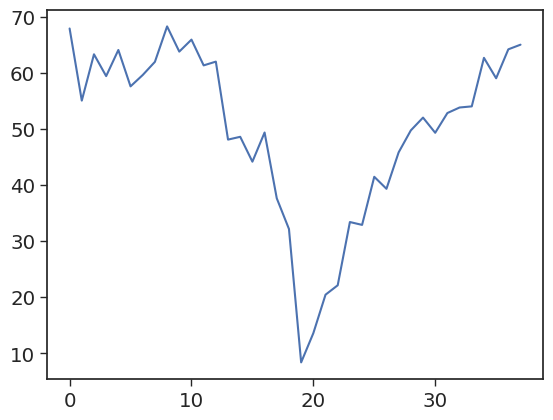

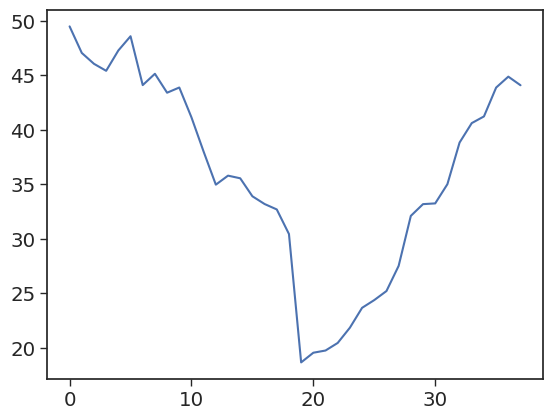

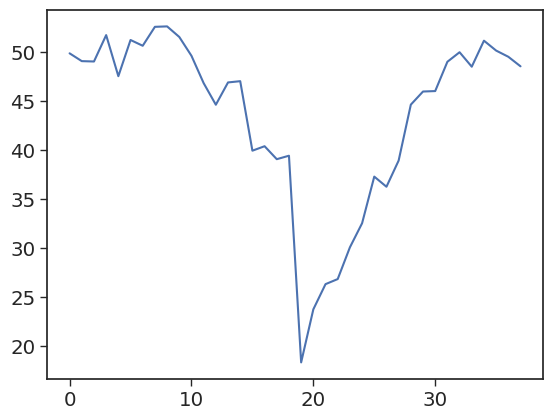

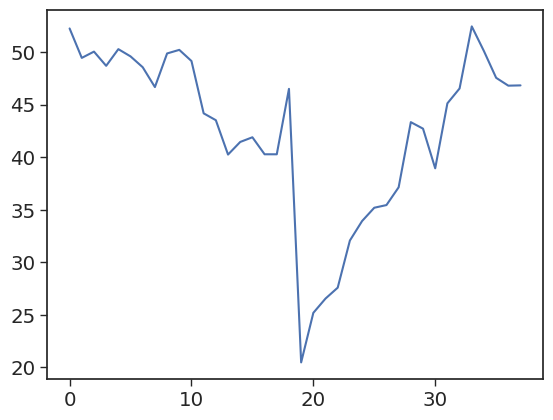

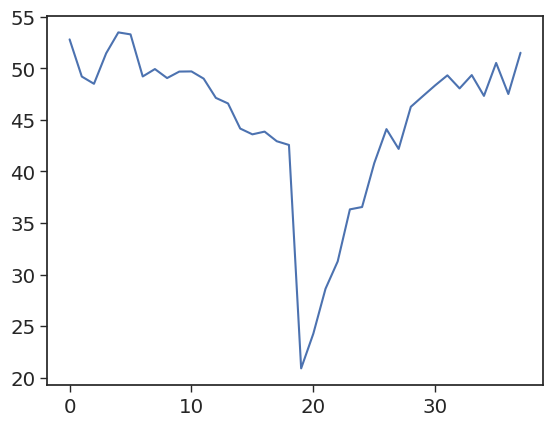

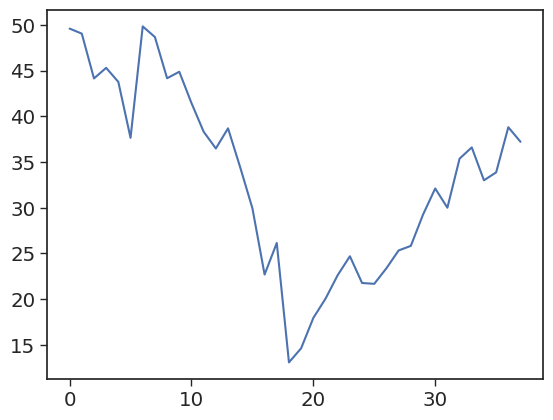

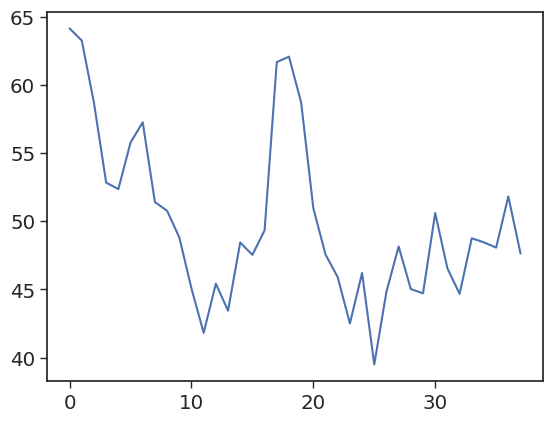

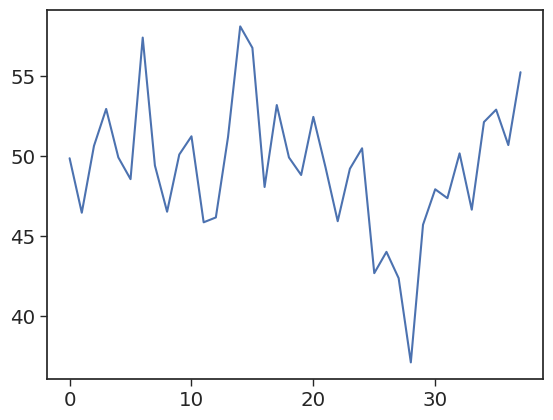

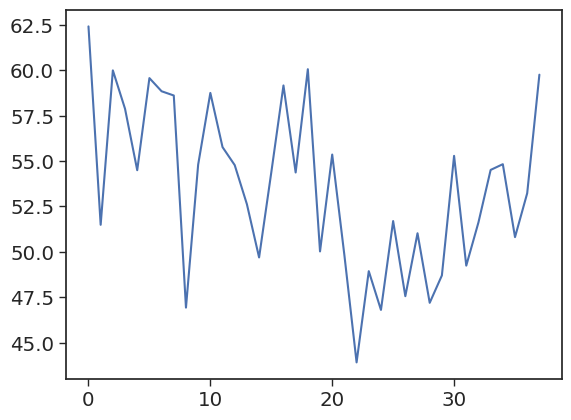

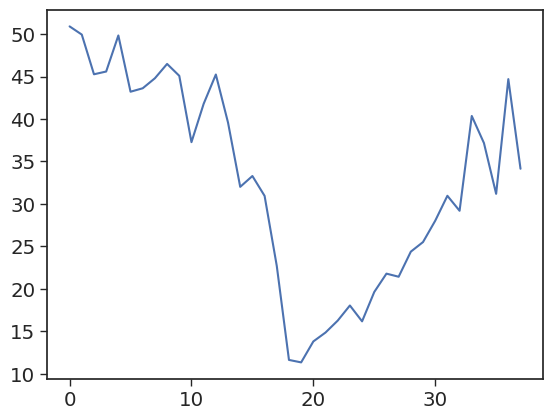

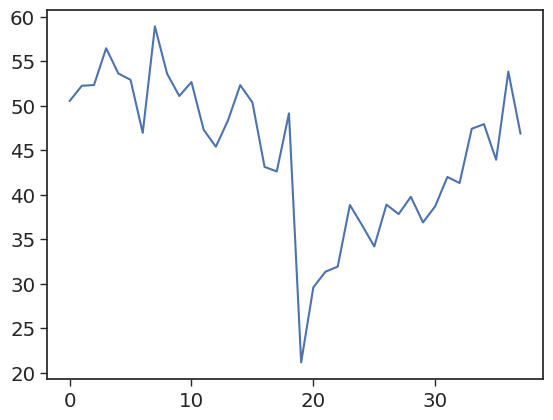

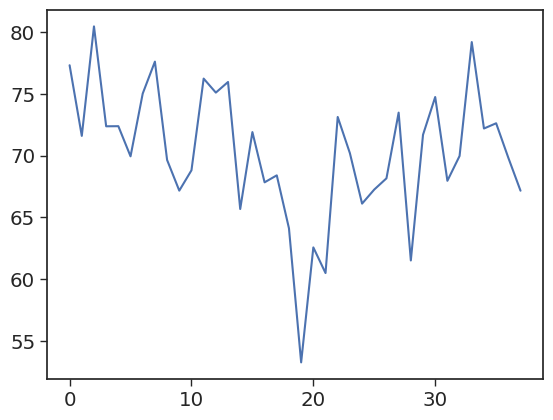

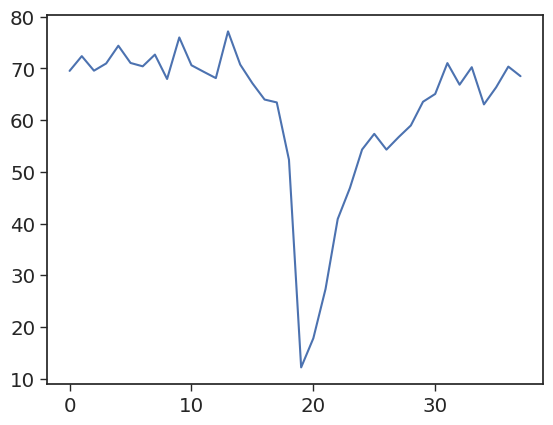

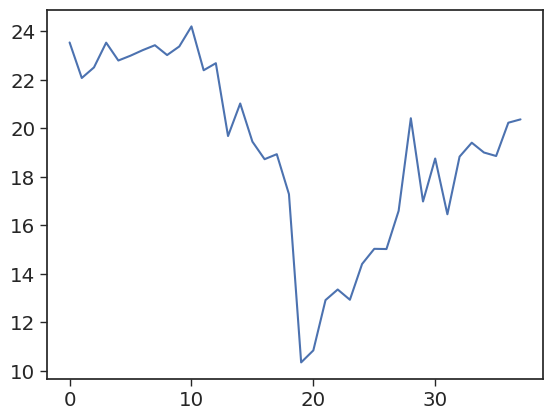

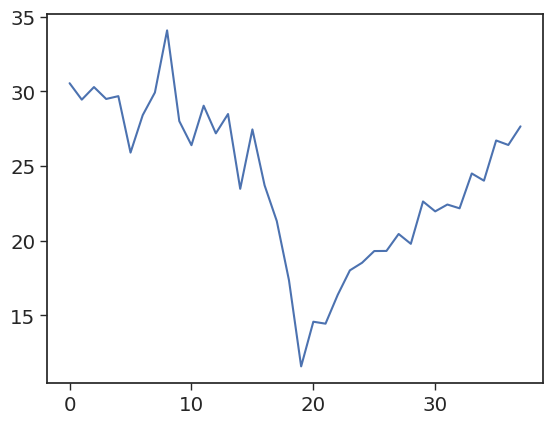

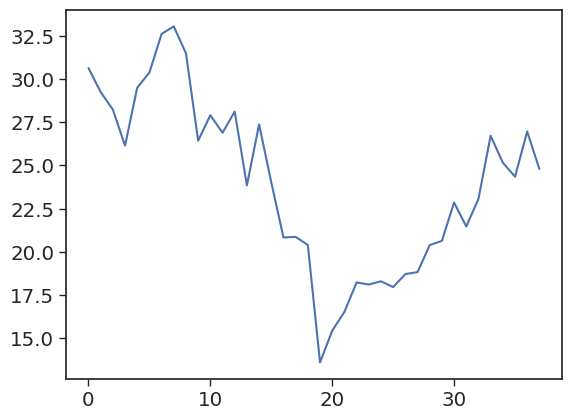

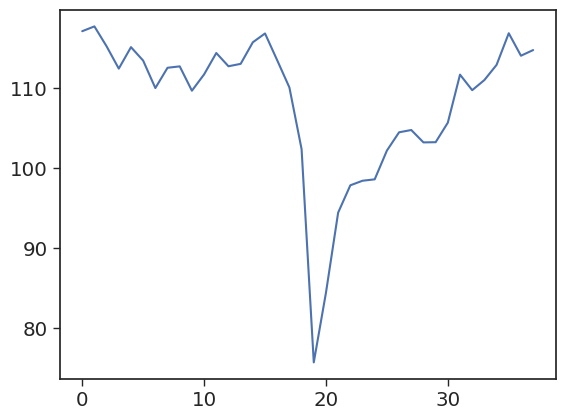

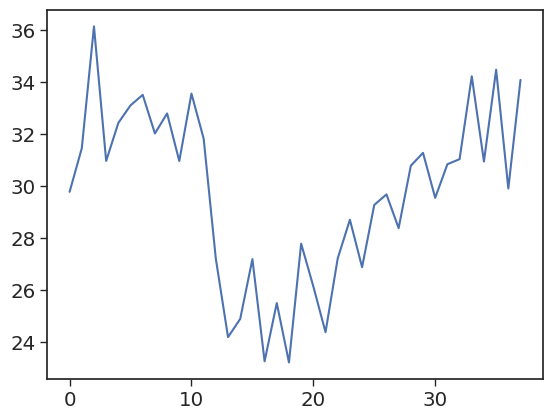

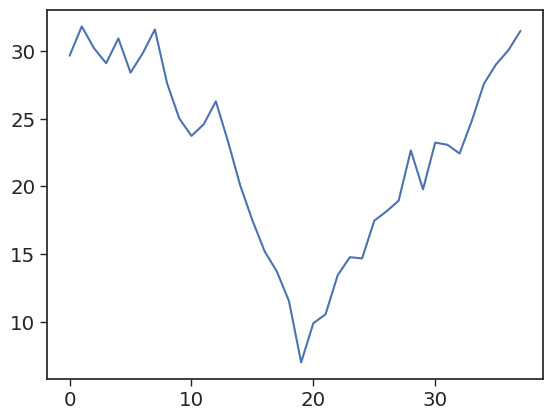

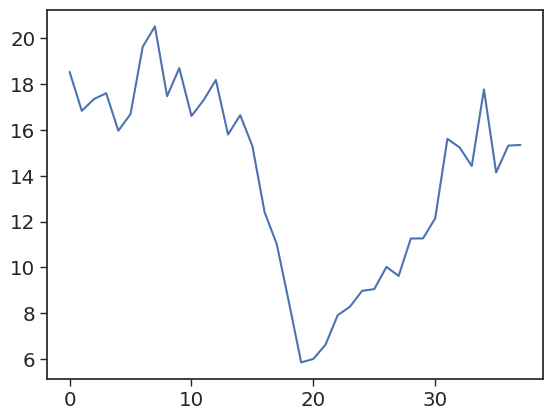

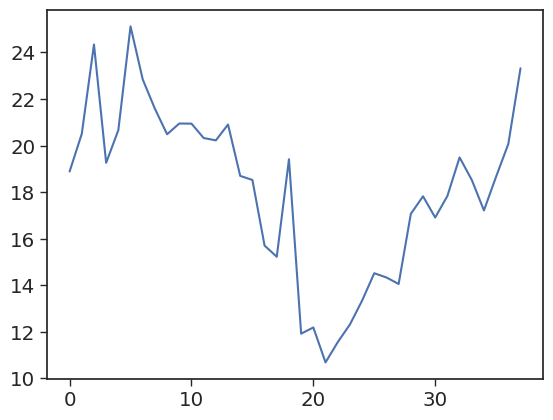

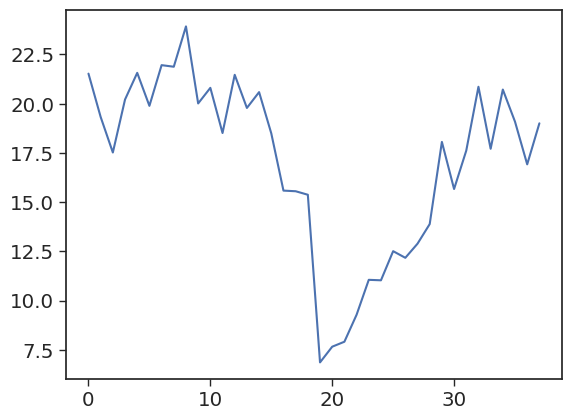

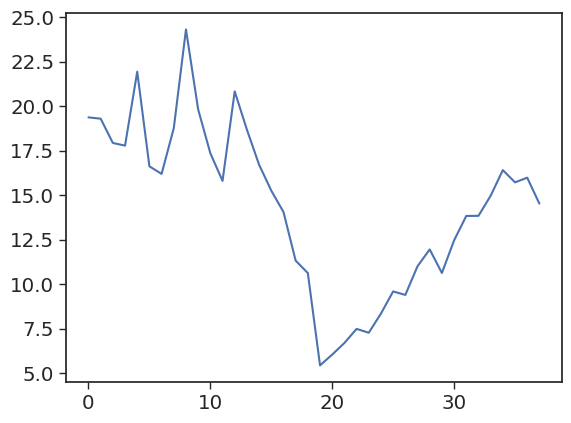

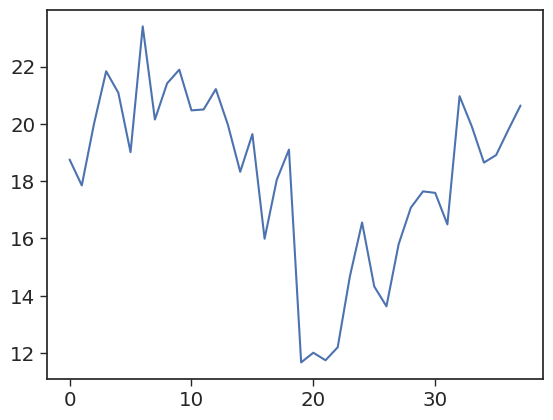

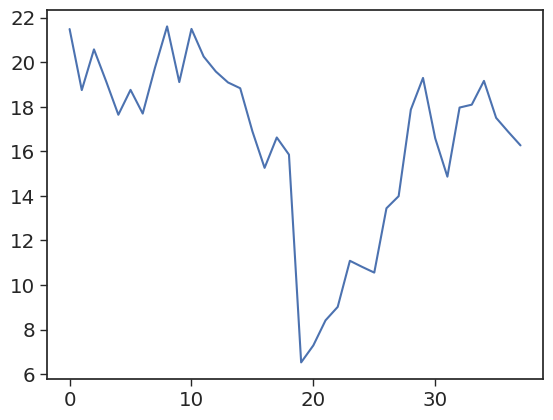

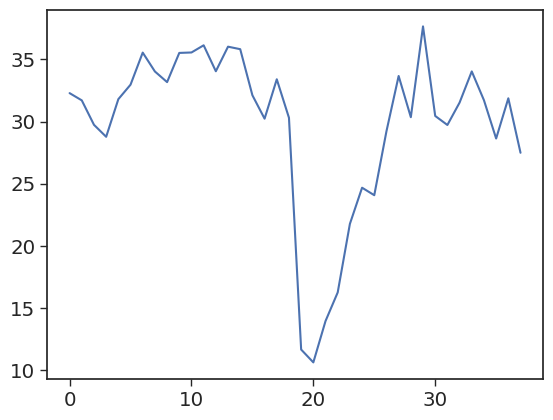

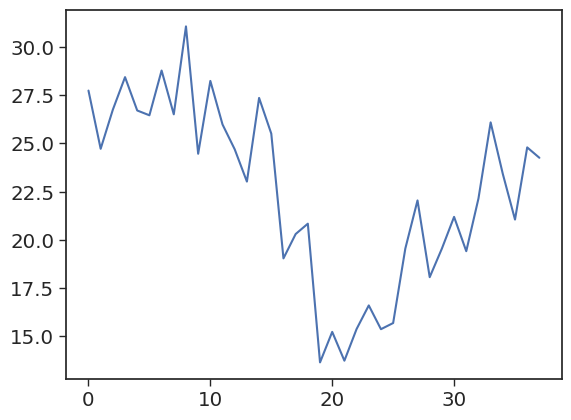

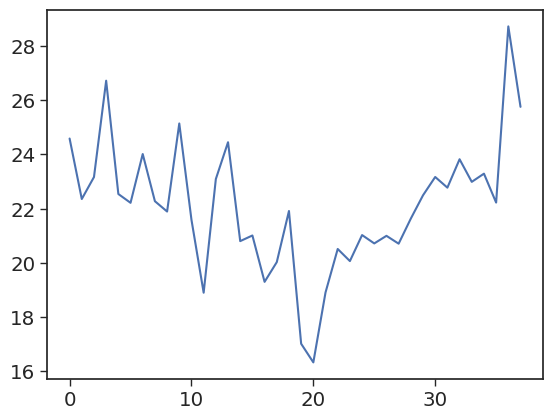

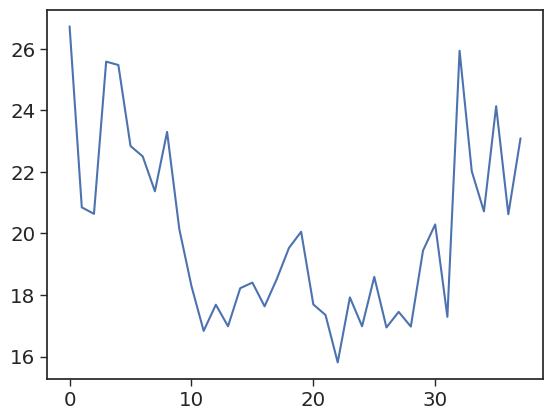

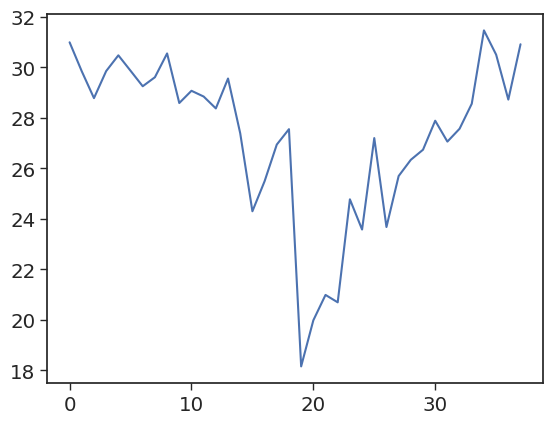

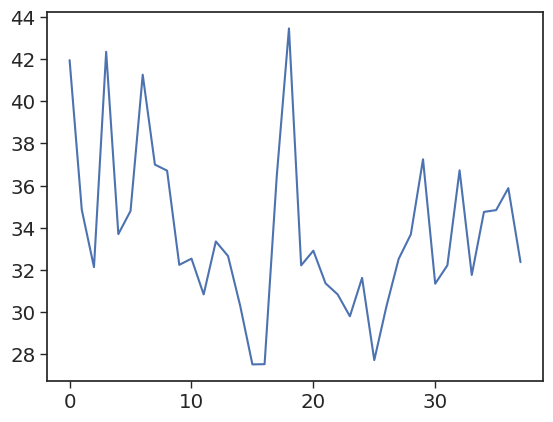

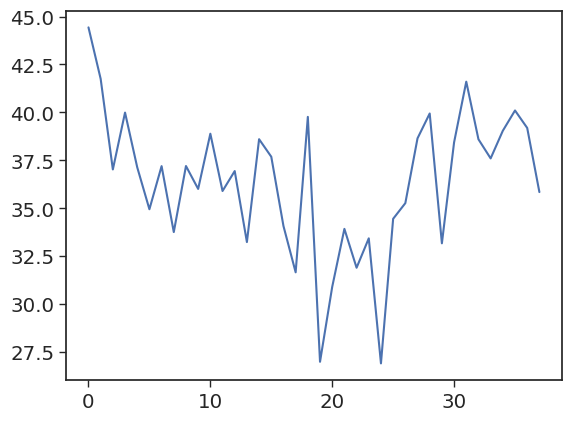

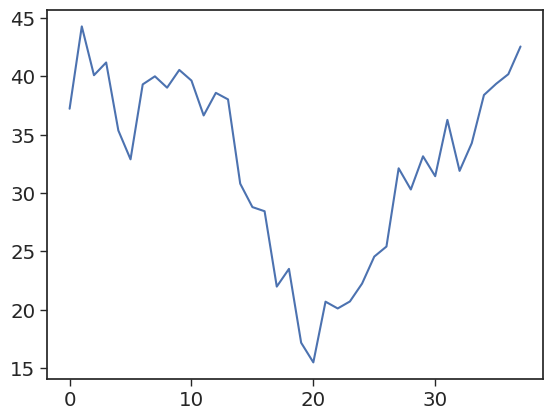

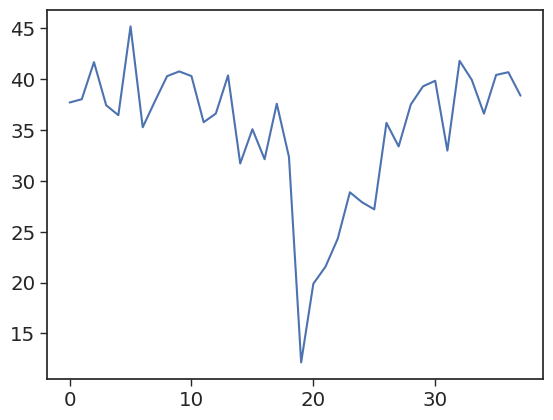

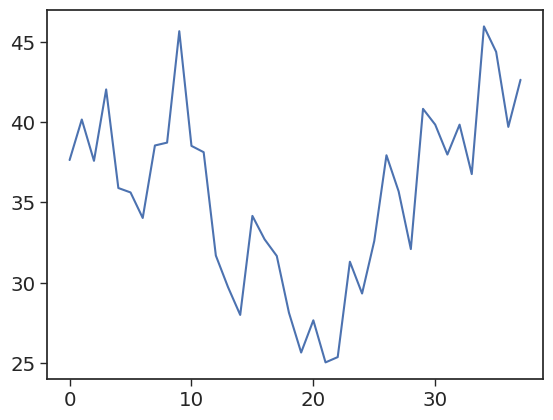

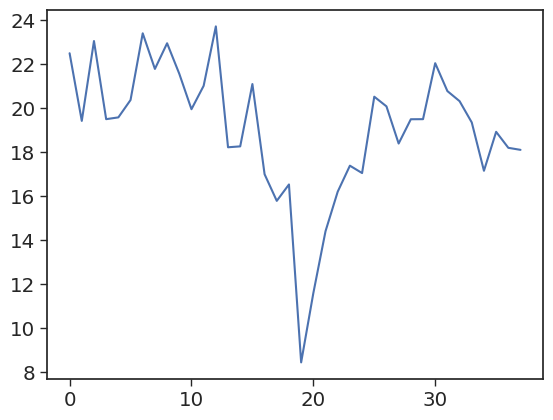

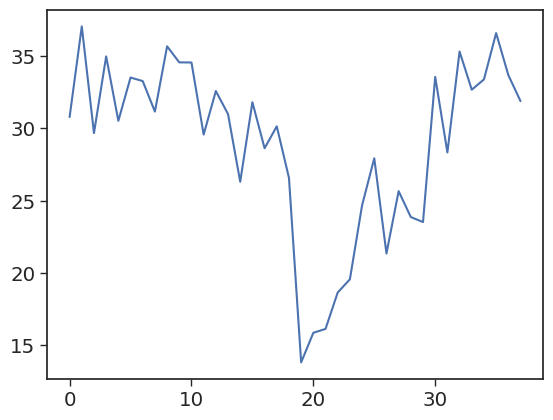

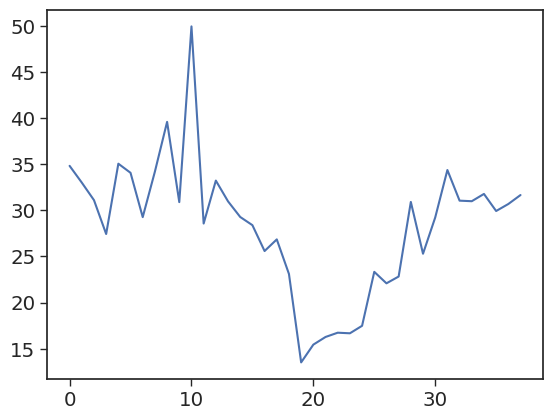

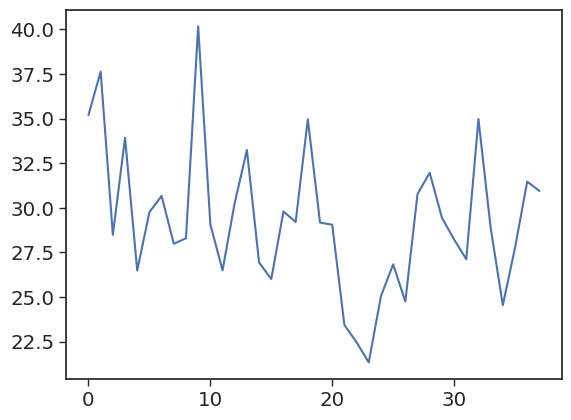

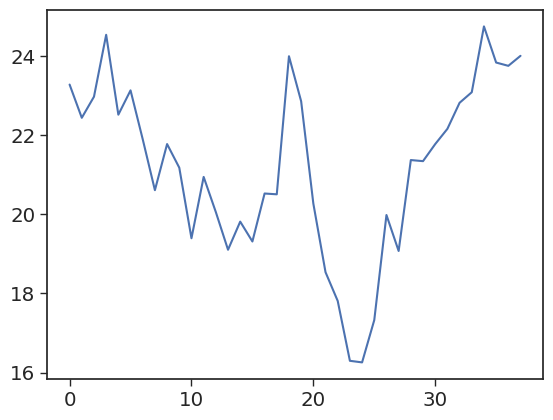

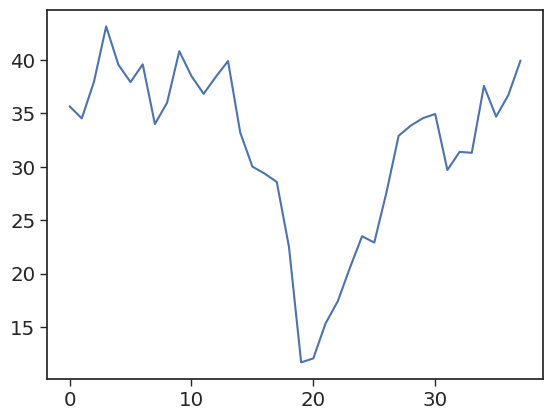

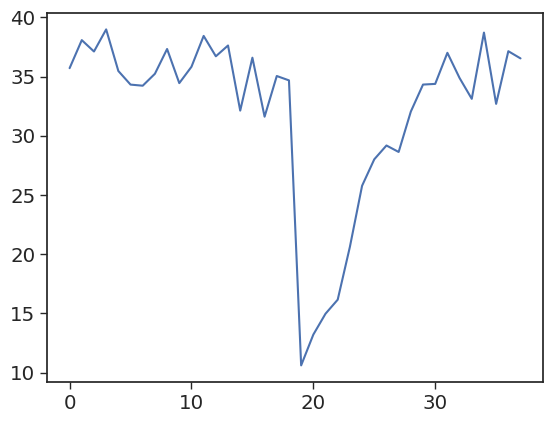

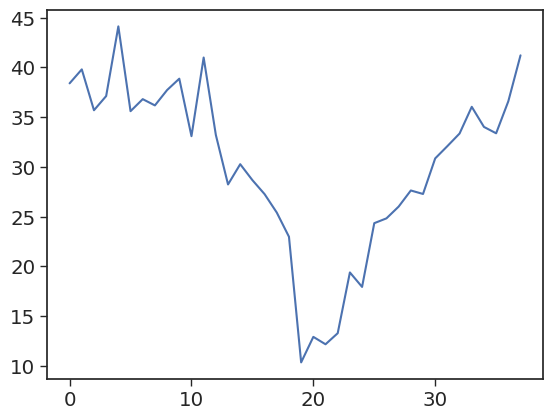

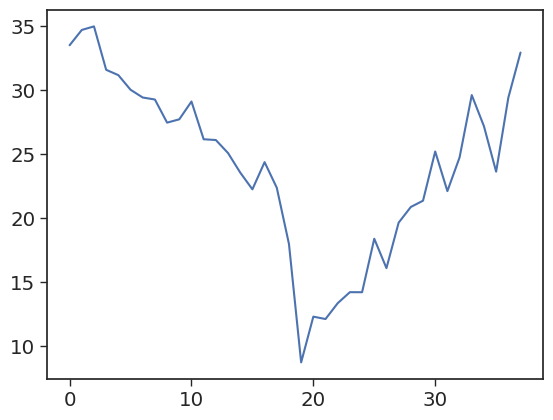

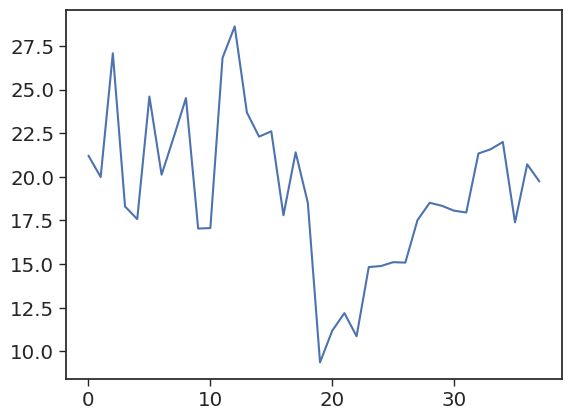

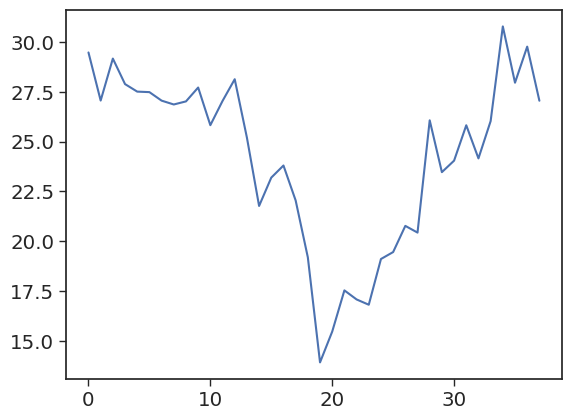

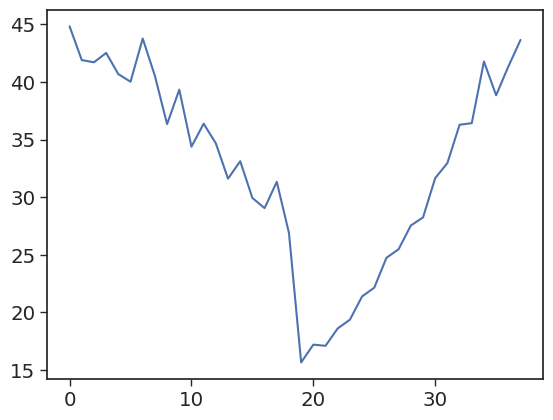

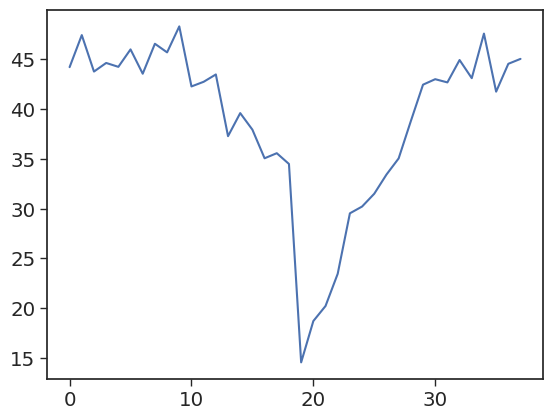

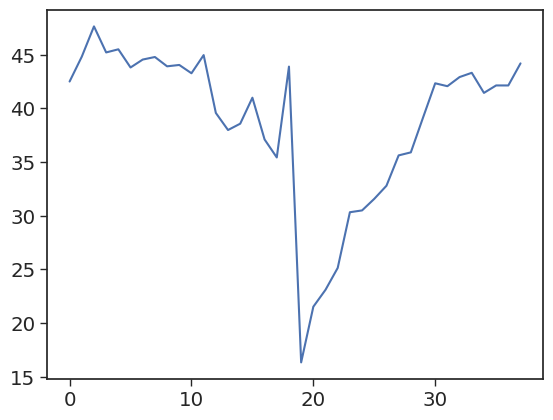

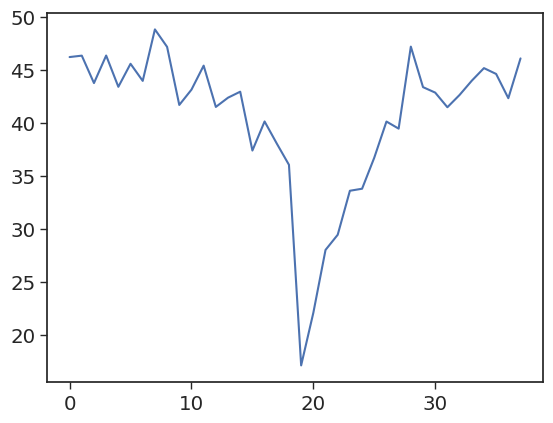

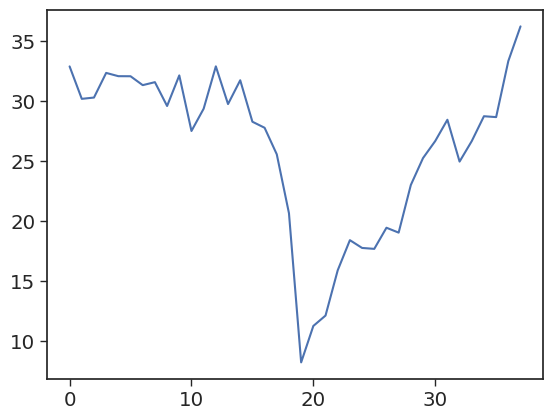

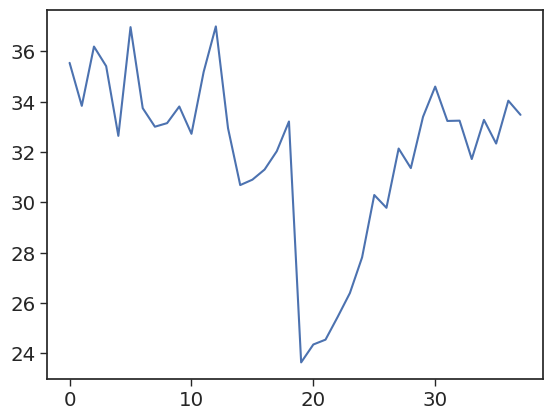

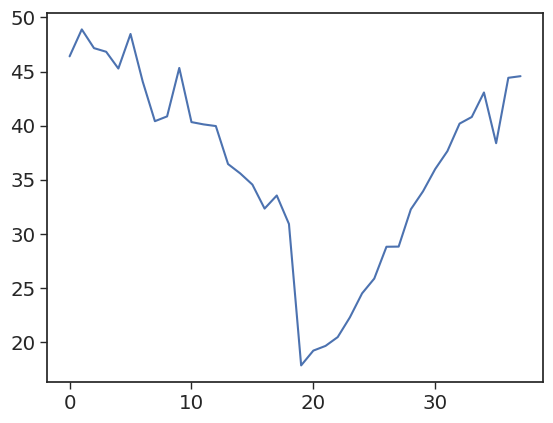

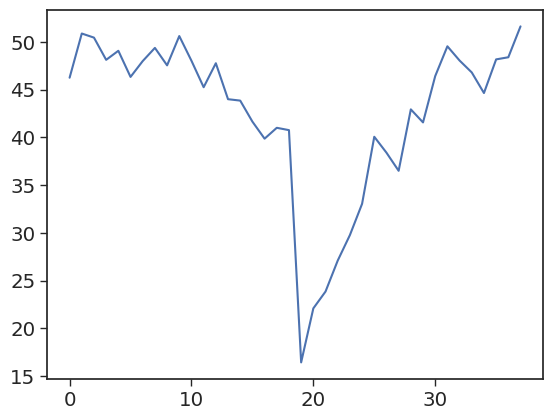

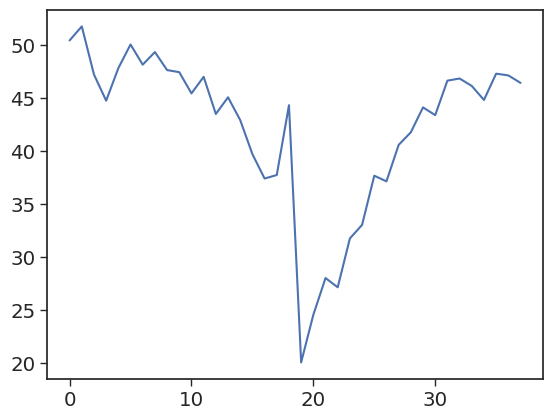

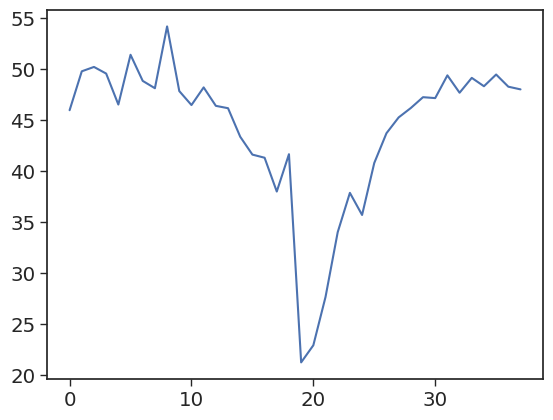

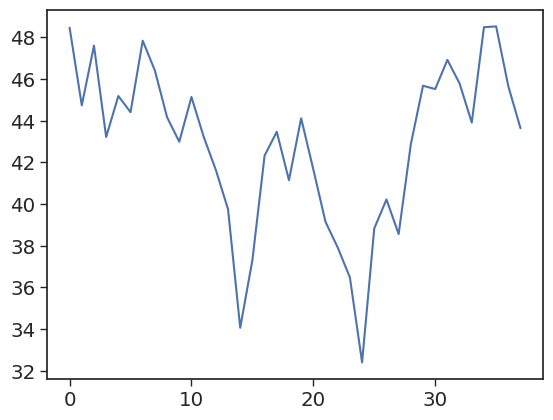

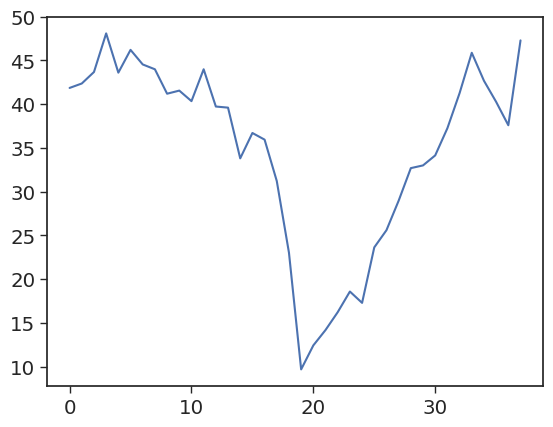

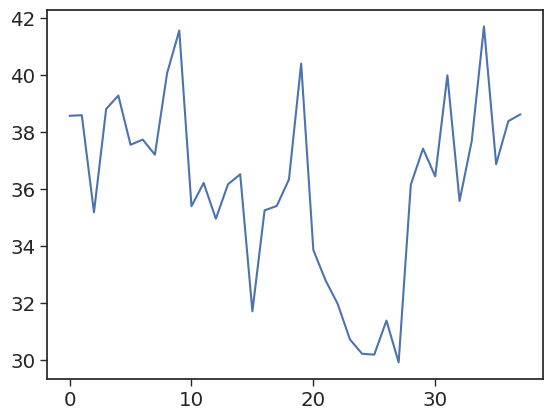

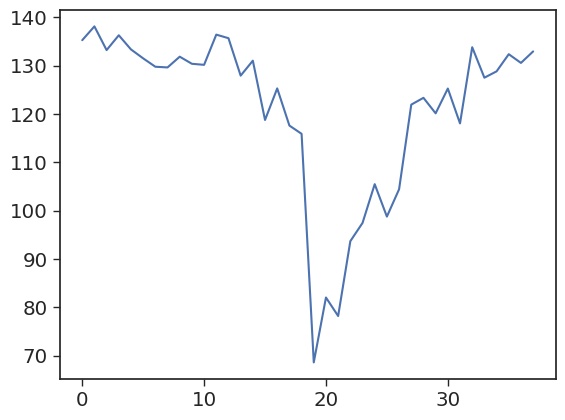

In [166]:
for i in np.array(raw_preds['PC-3'])[np.argwhere(embedding[:, 0] > 0).flatten()]:
    plt.plot(i)
    plt.show()

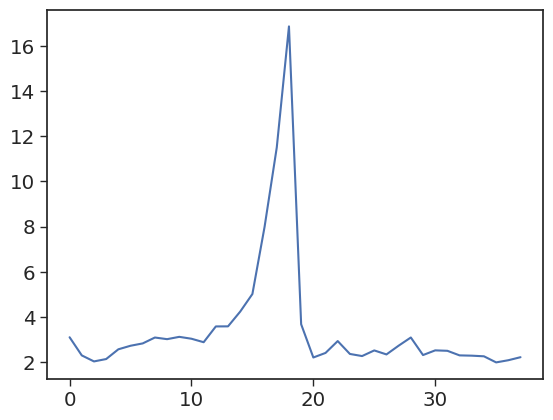

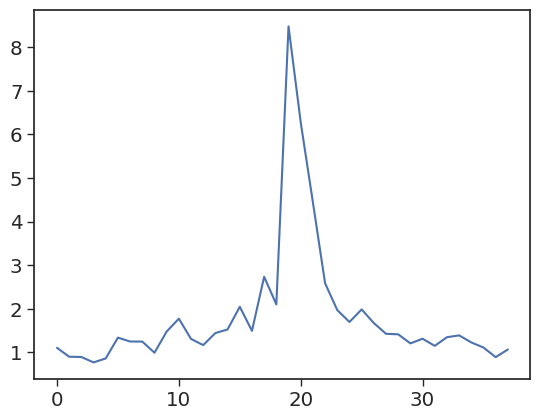

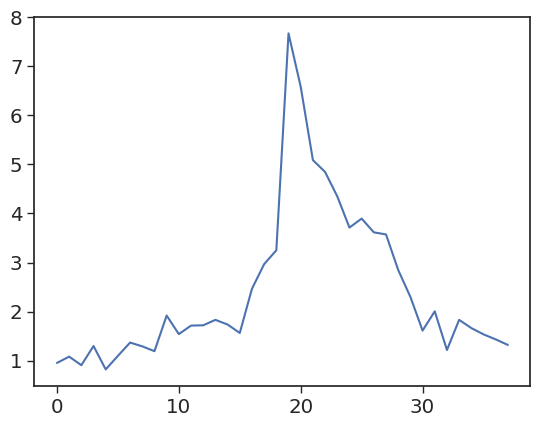

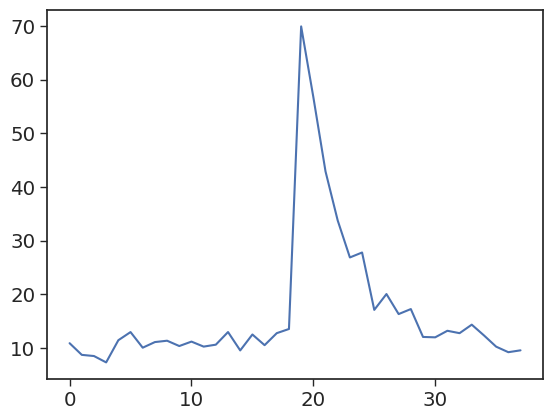

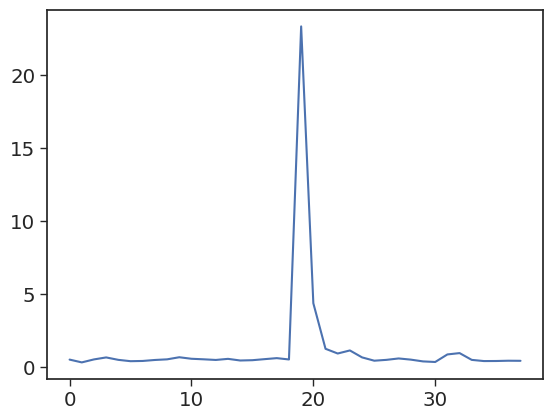

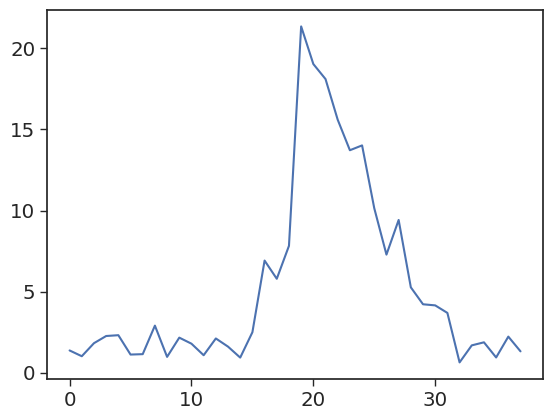

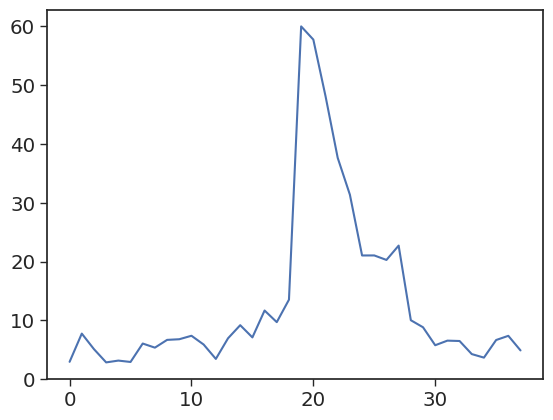

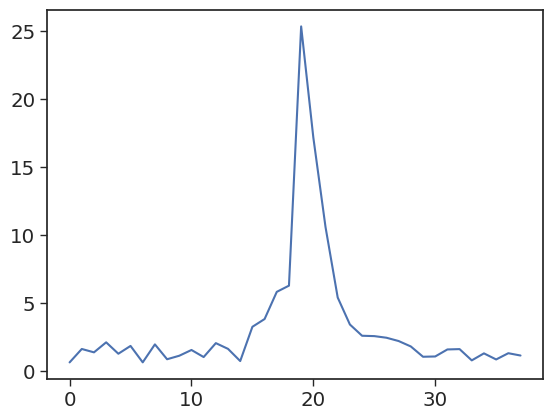

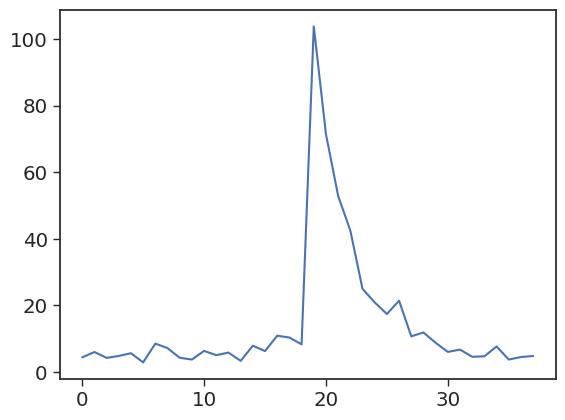

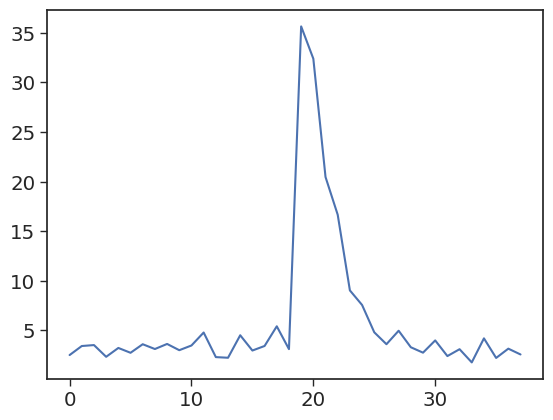

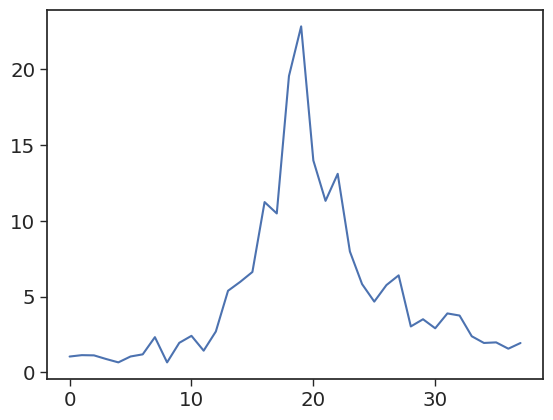

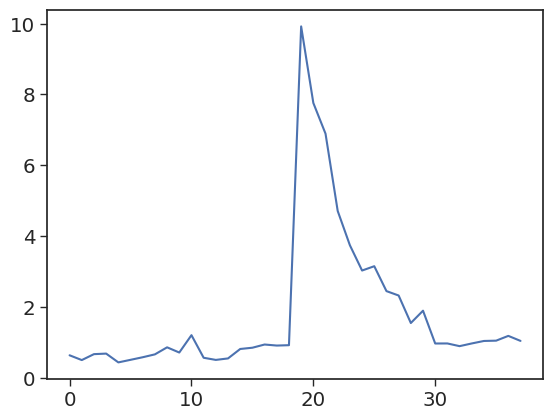

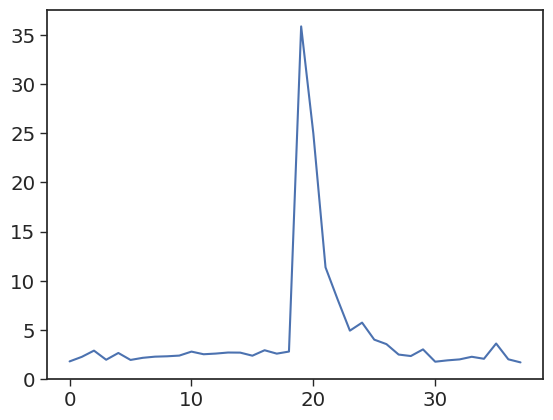

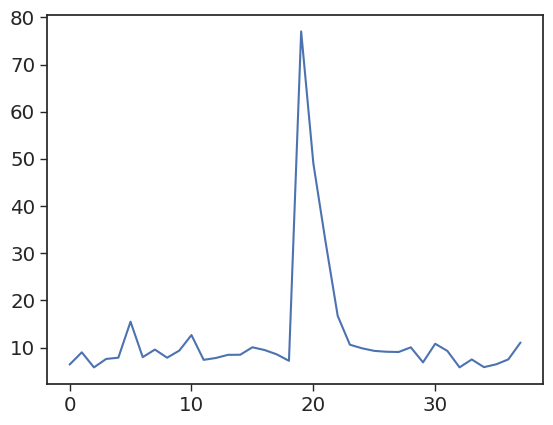

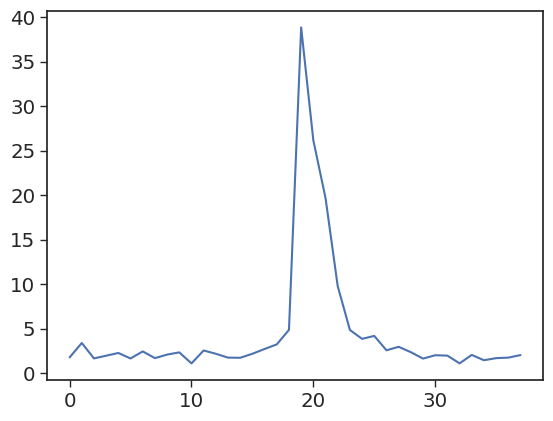

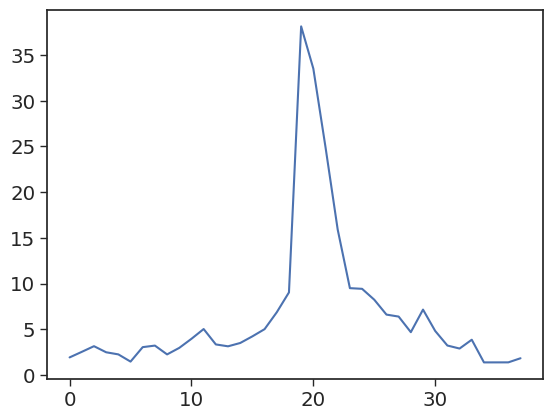

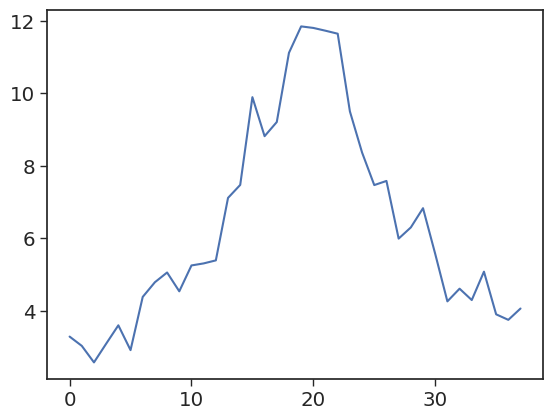

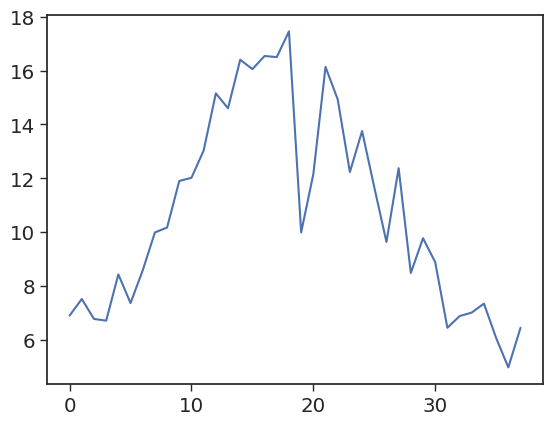

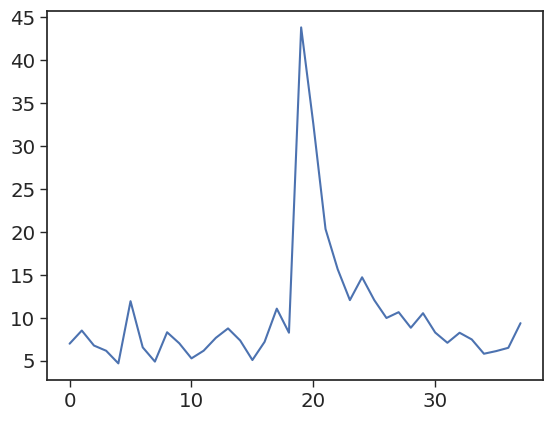

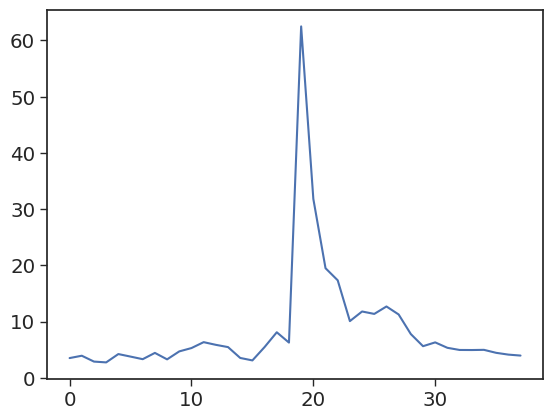

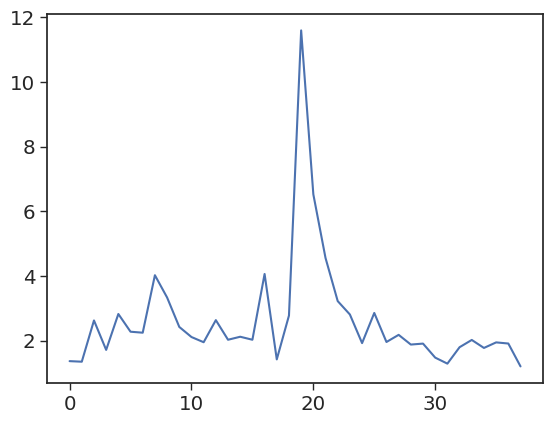

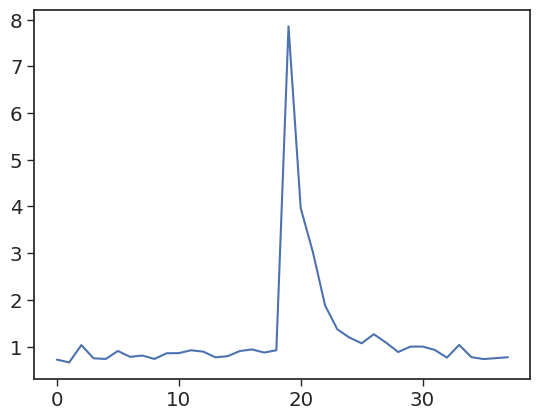

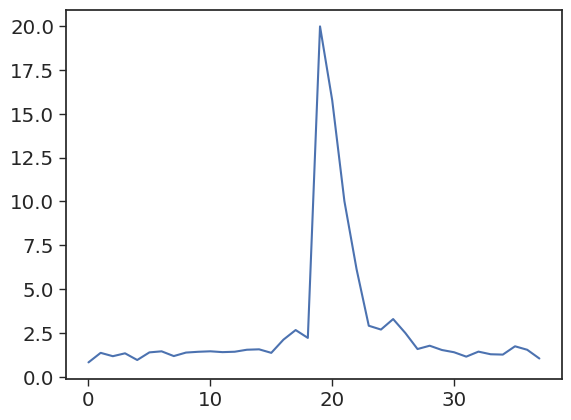

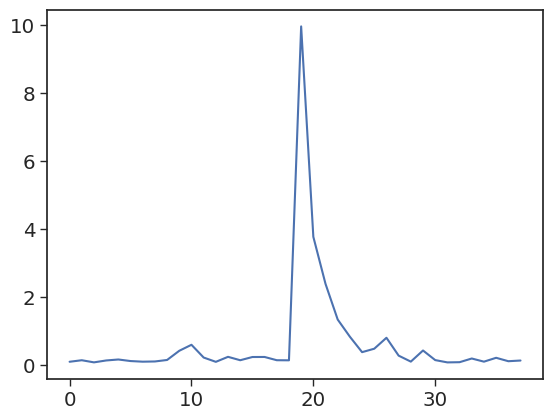

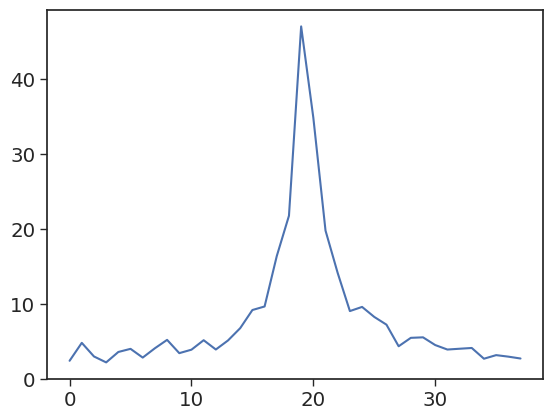

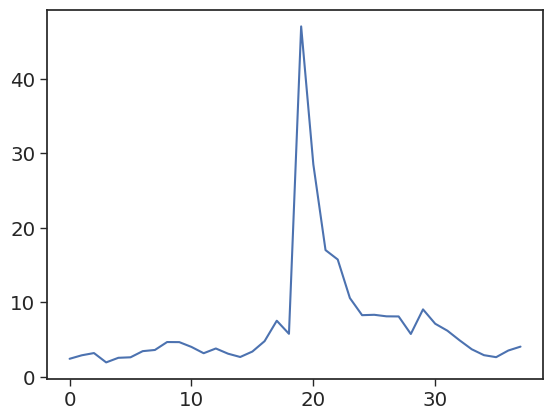

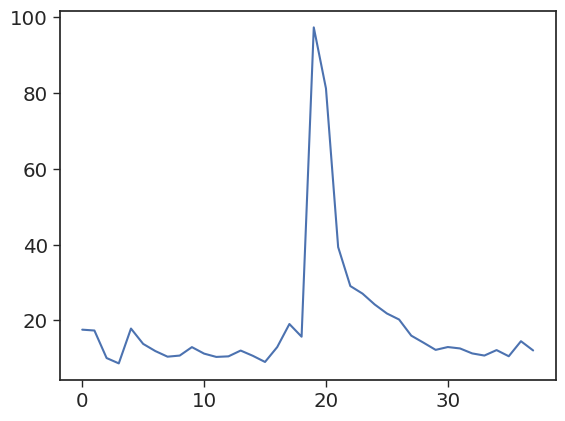

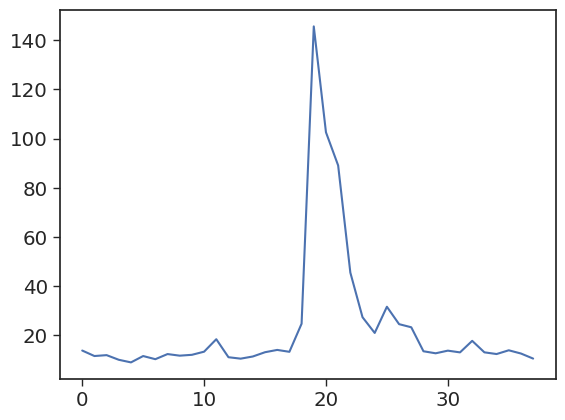

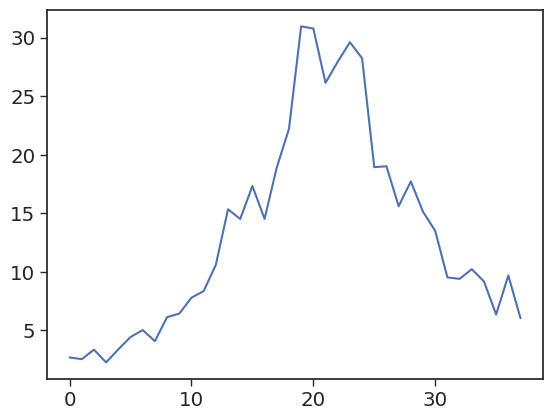

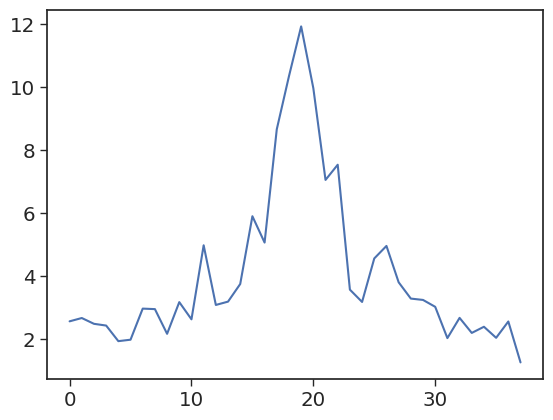

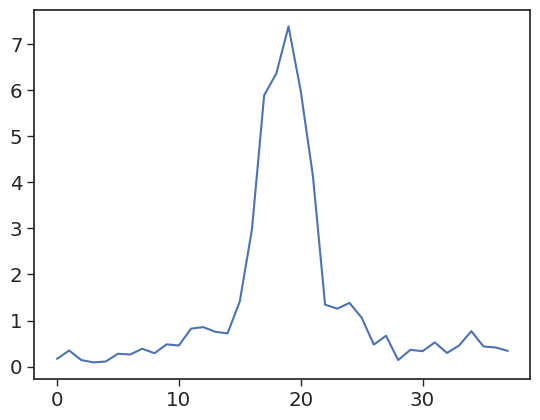

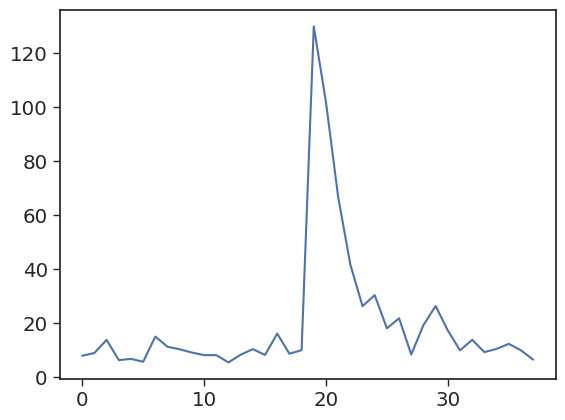

In [165]:
for i in np.array(raw_preds['PC-3'])[np.argwhere(embedding[:, 0] < 0).flatten()]:
    plt.plot(i)
    plt.show()

<Axes: >

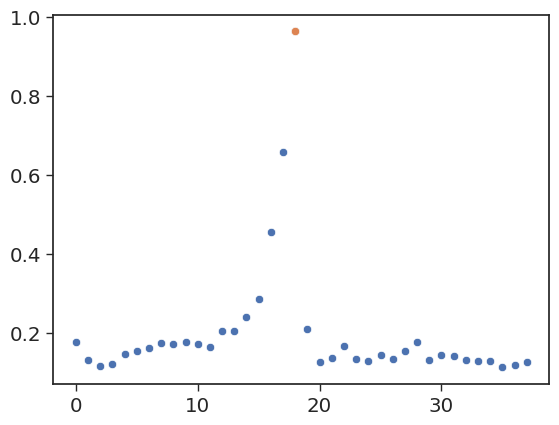

In [94]:
sns.scatterplot(x=range(len(norm_effects)), y=norm_effects)
tile_i = np.argwhere(row['tile_start']==cre_tiles_starts).flatten()[0]
sns.scatterplot(x=[tile_i], y=norm_effects[tile_i:tile_i+1])

In [78]:
x = res['mean_mut'][:,:,0]

In [79]:
tile_coords = pd.read_csv(f'../results/sufficiency_test/{model_name}/tile_coordinates.csv', index_col='Unnamed: 0').T
tss_tile = tile_coords.loc['tss'].T.values
cre_tile_coords = tile_coords.loc[[t for t in tile_coords.index if 'tss' not in t]]
cre_tiles_starts = cre_tile_coords[0].values

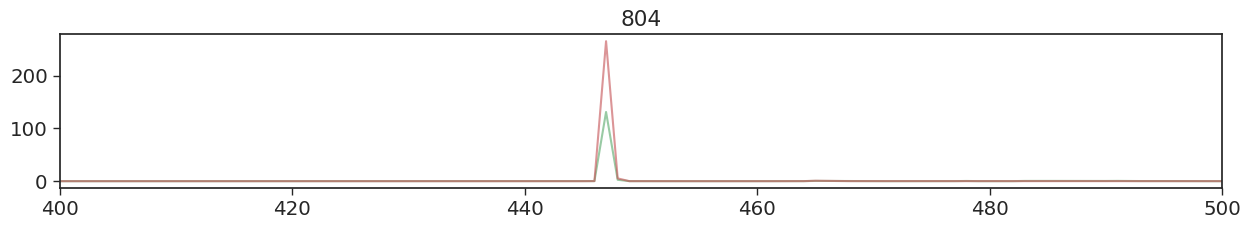

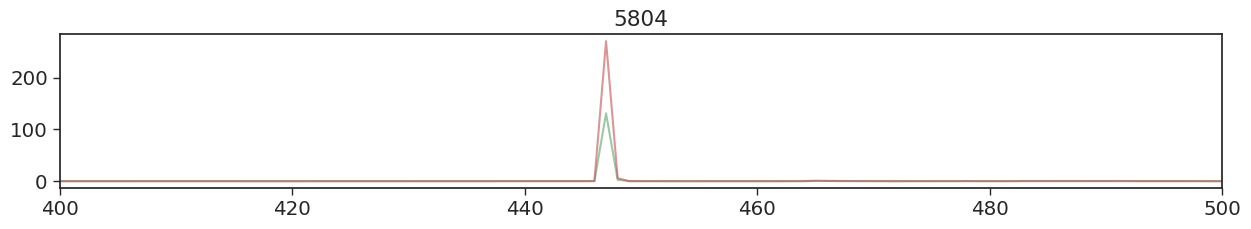

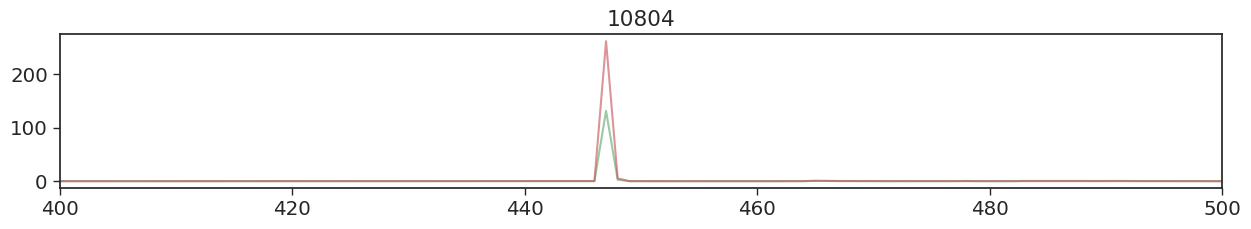

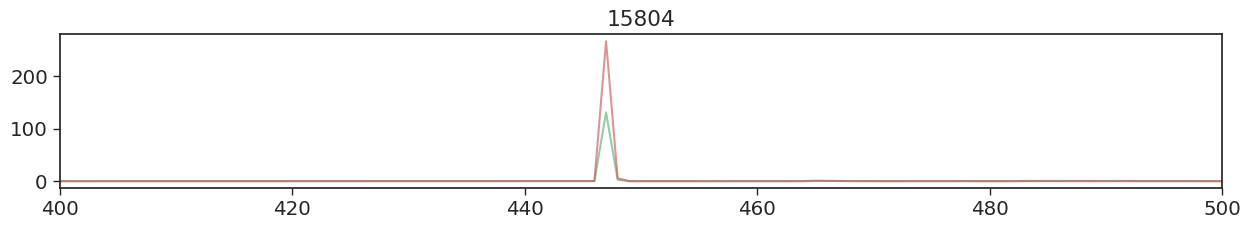

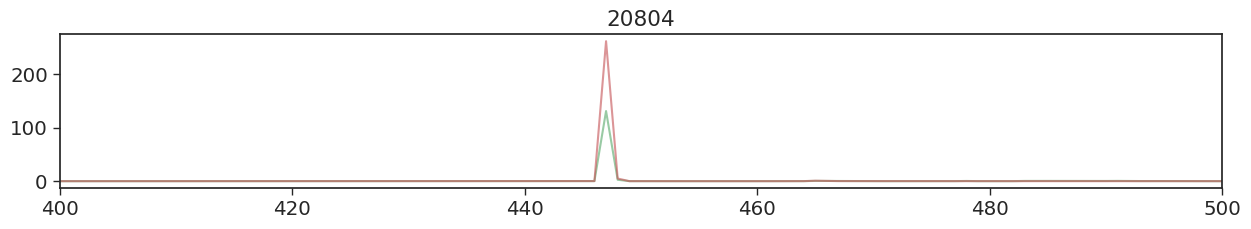

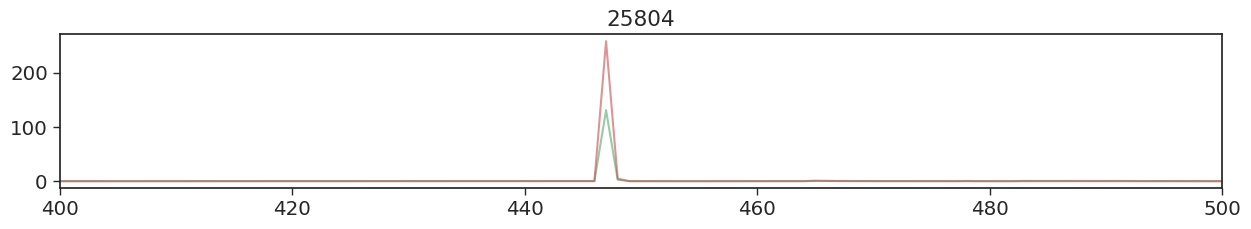

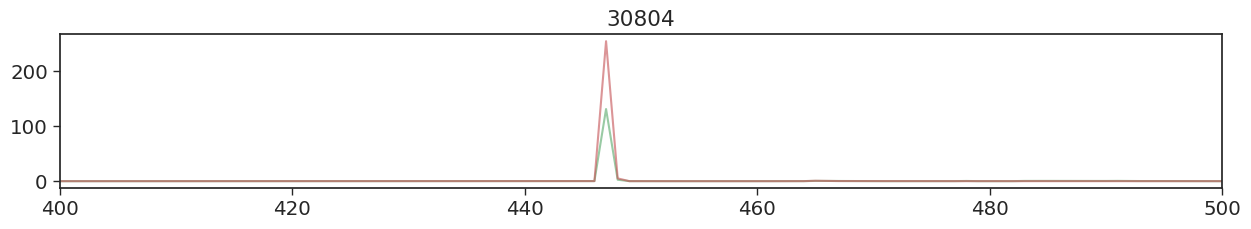

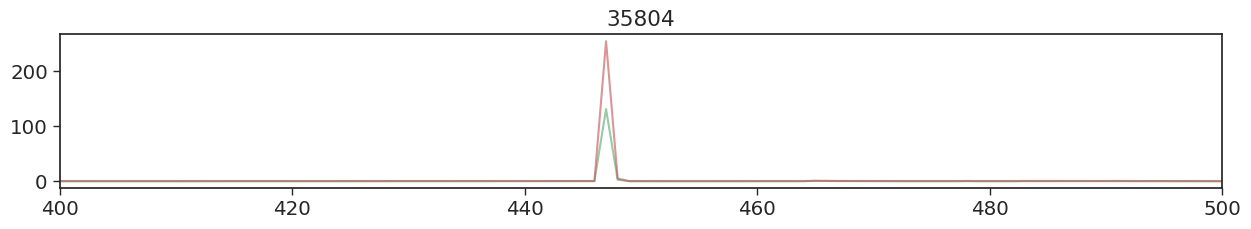

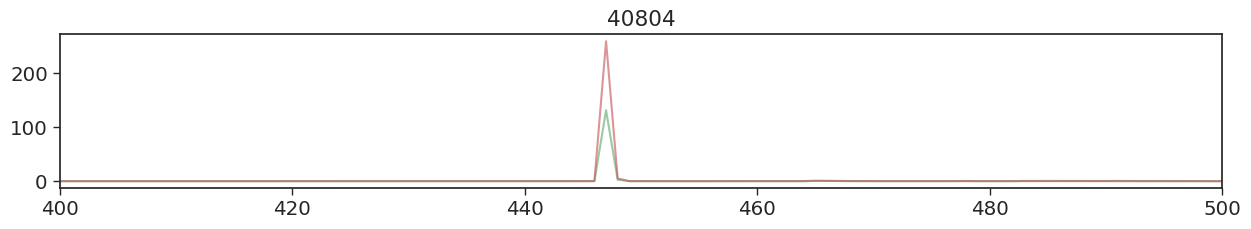

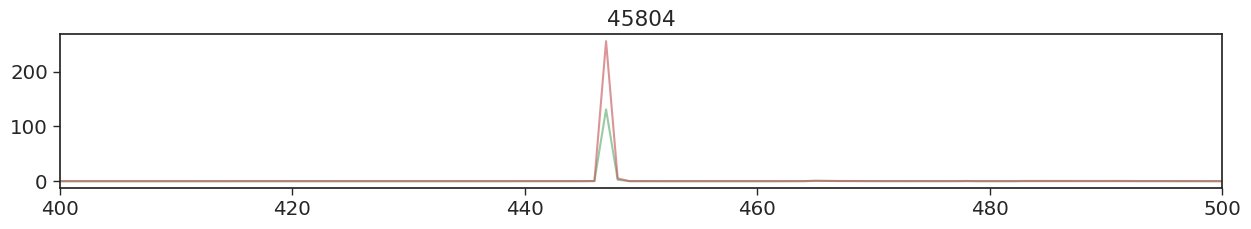

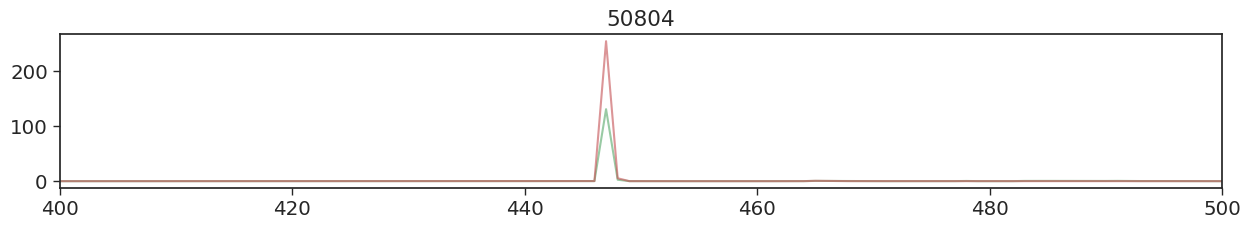

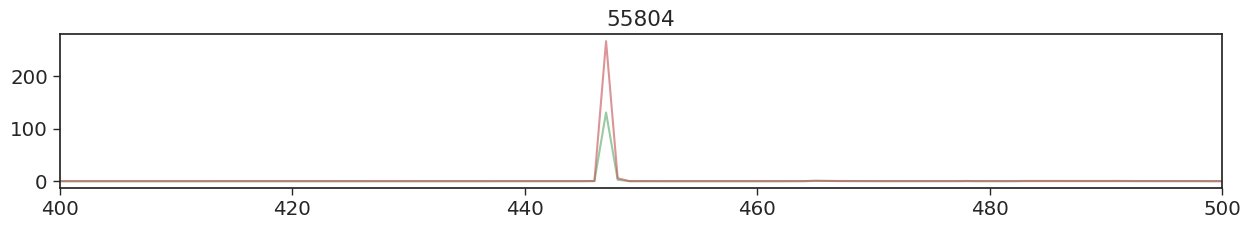

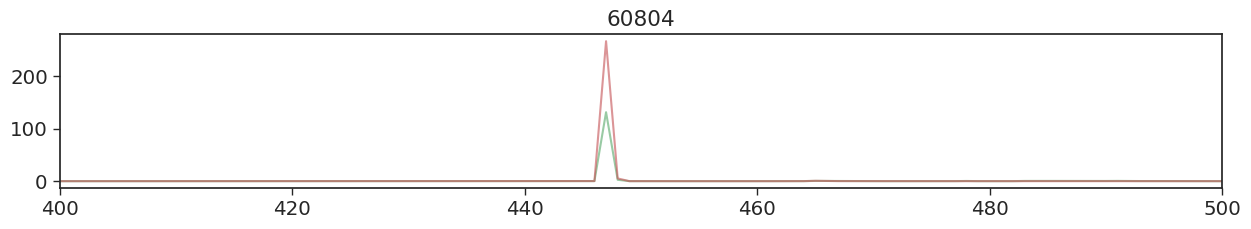

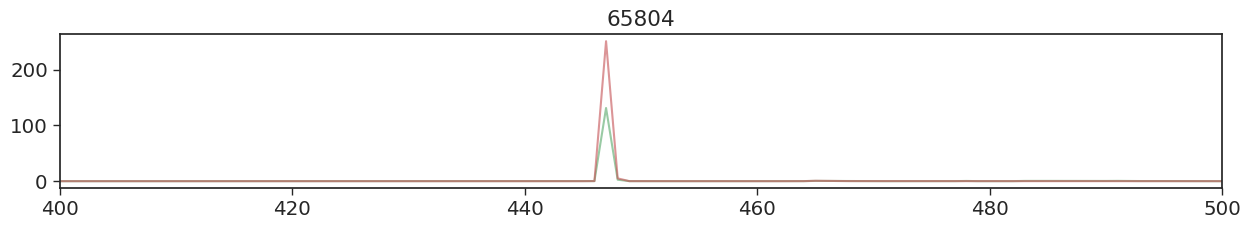

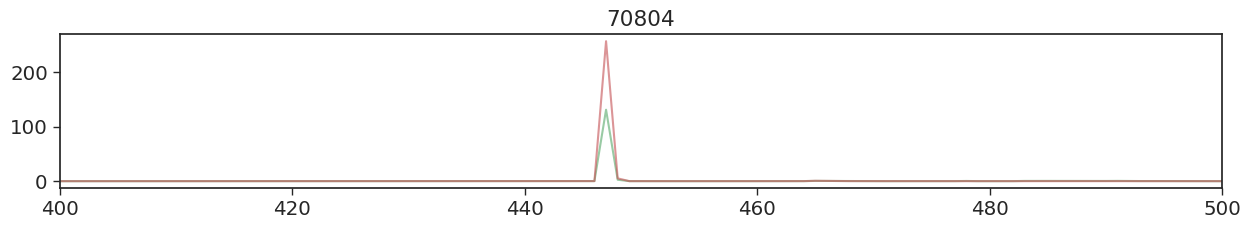

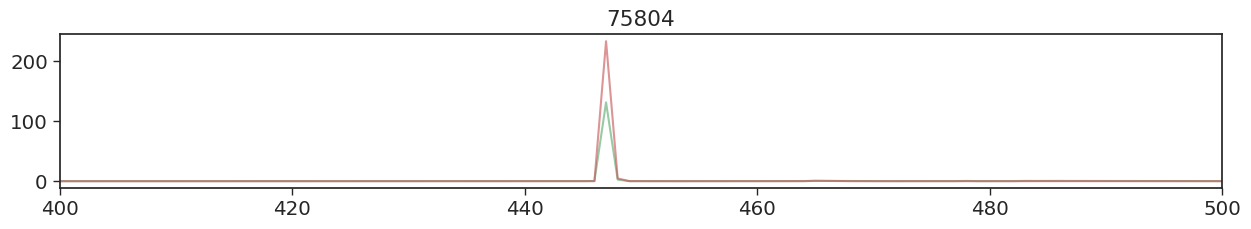

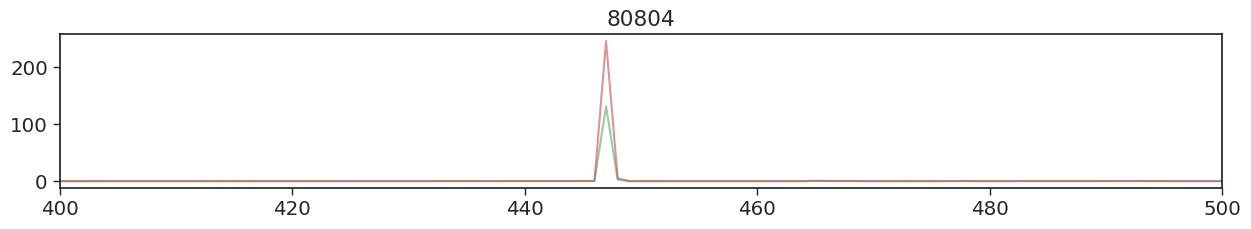

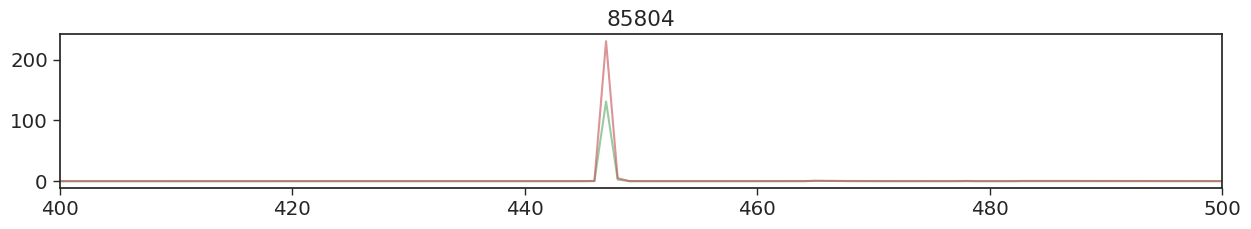

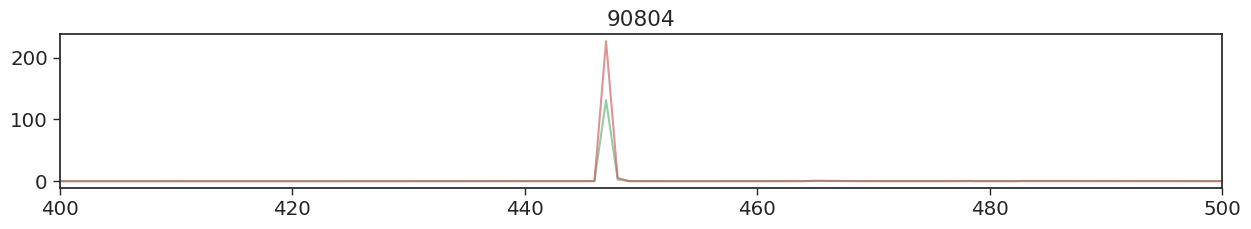

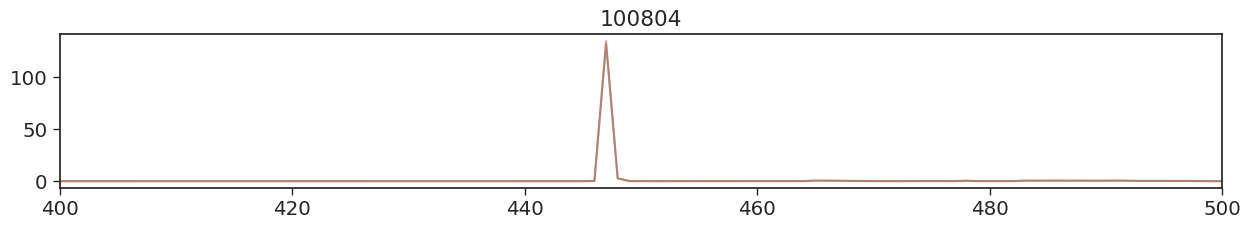

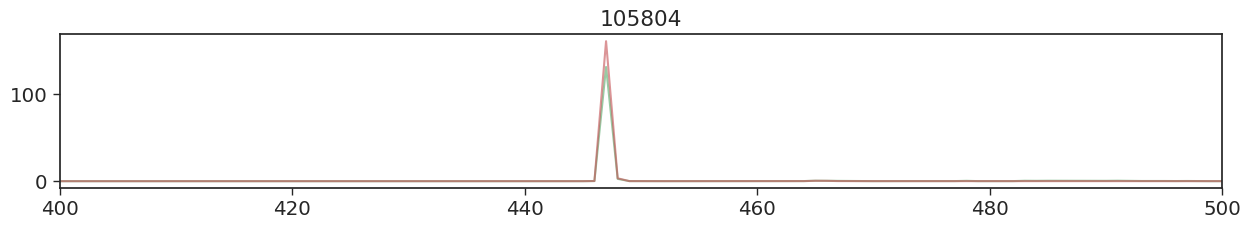

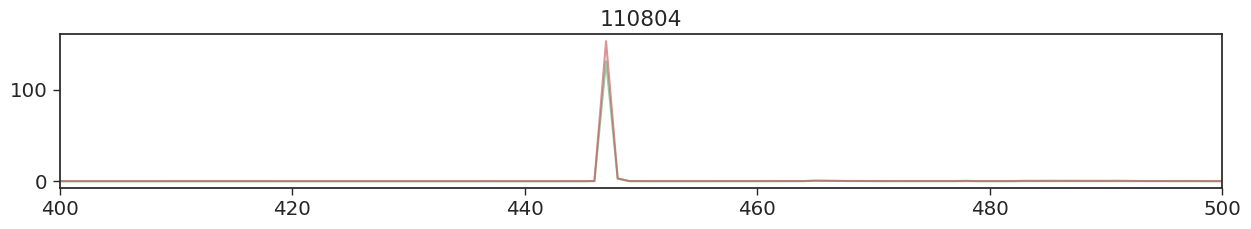

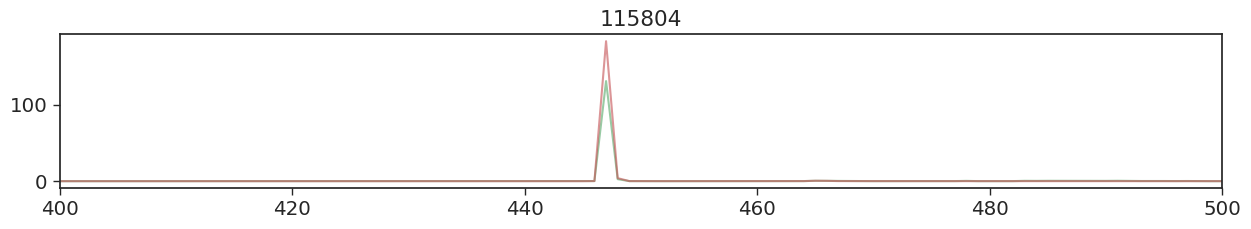

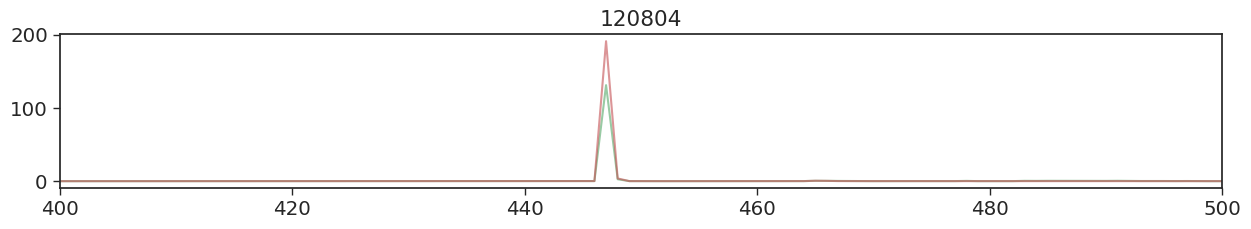

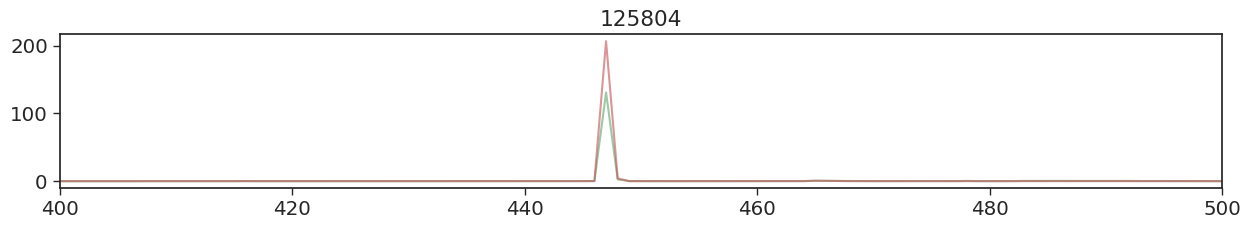

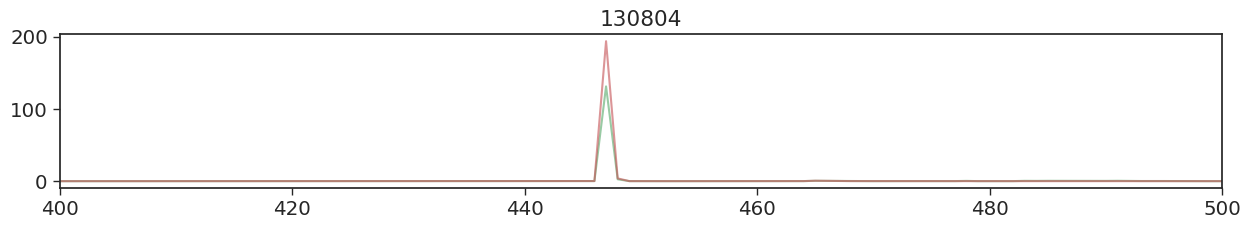

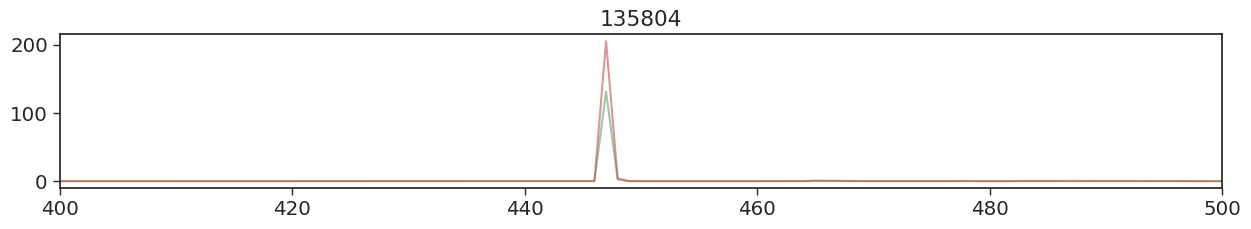

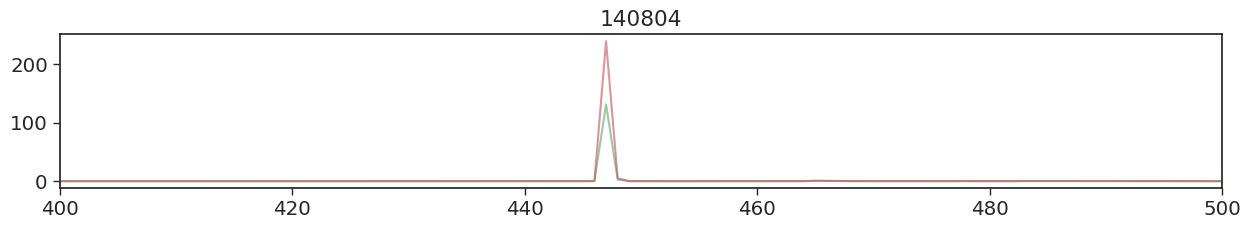

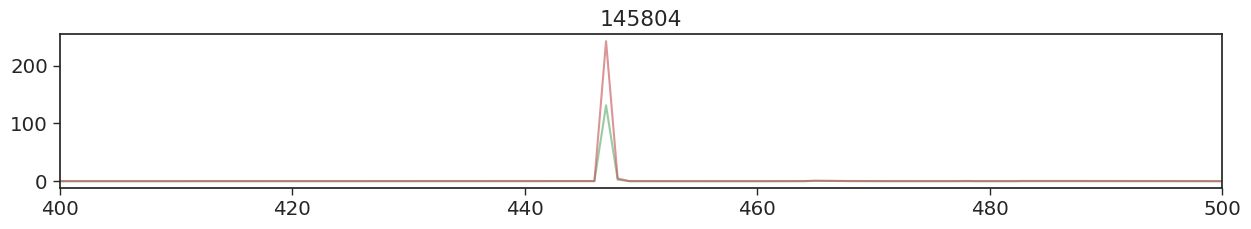

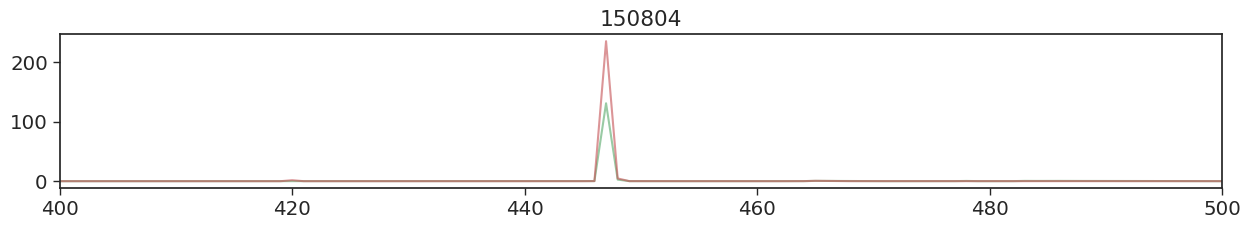

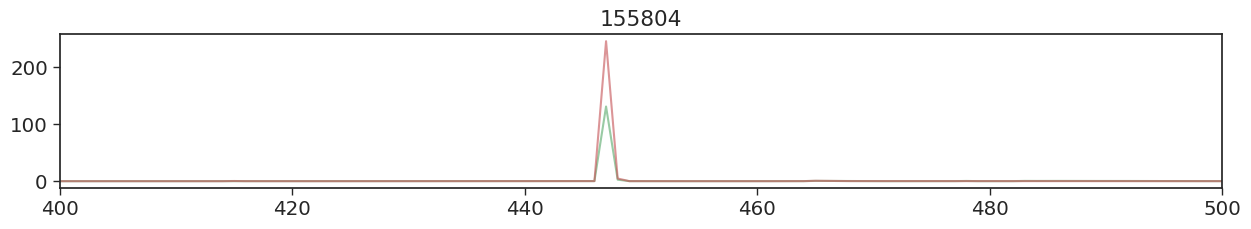

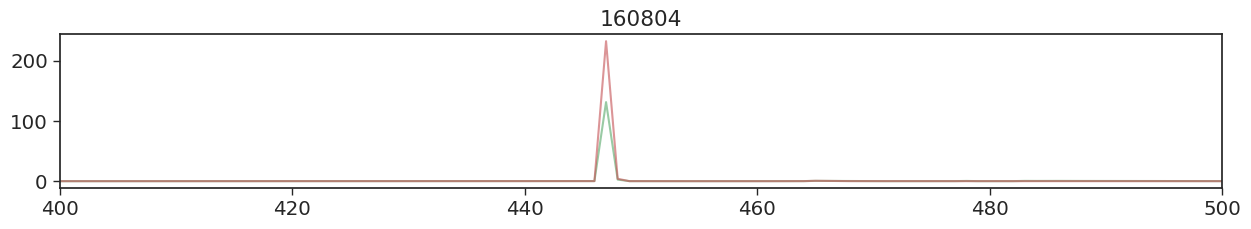

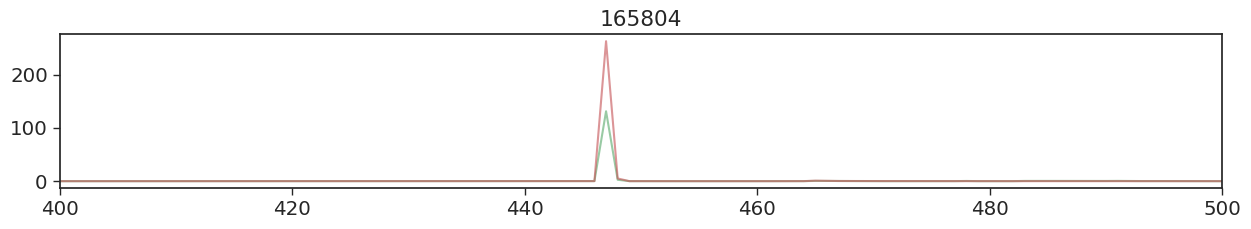

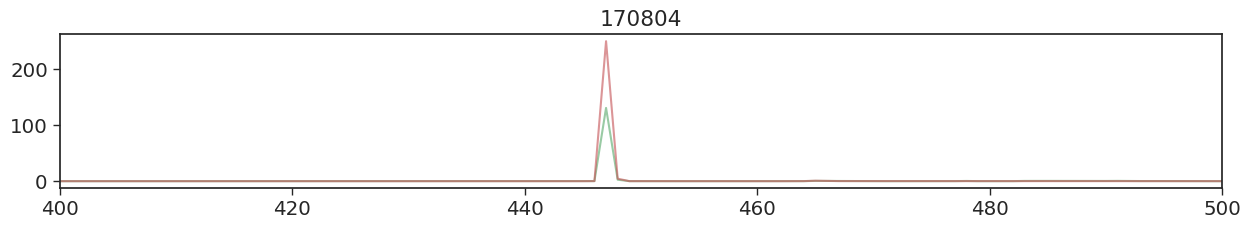

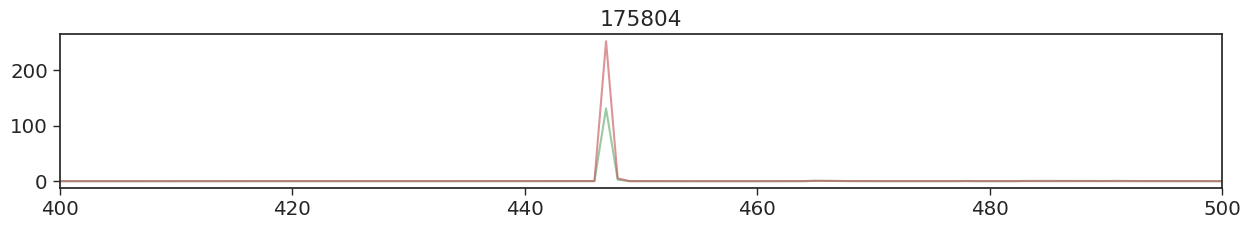

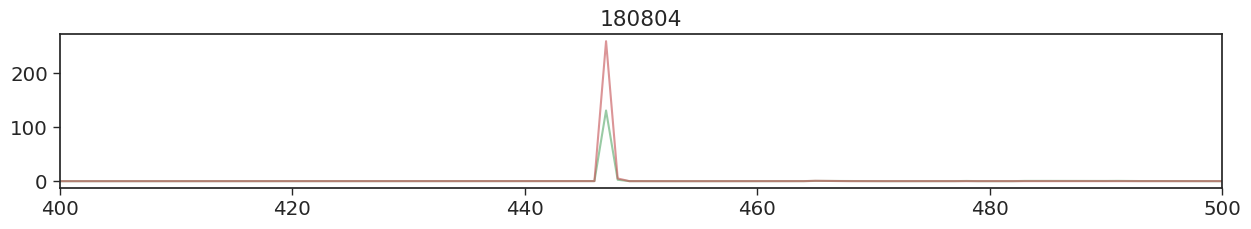

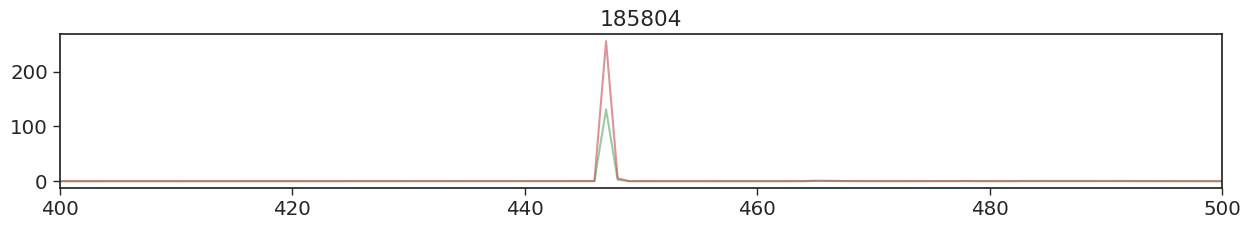

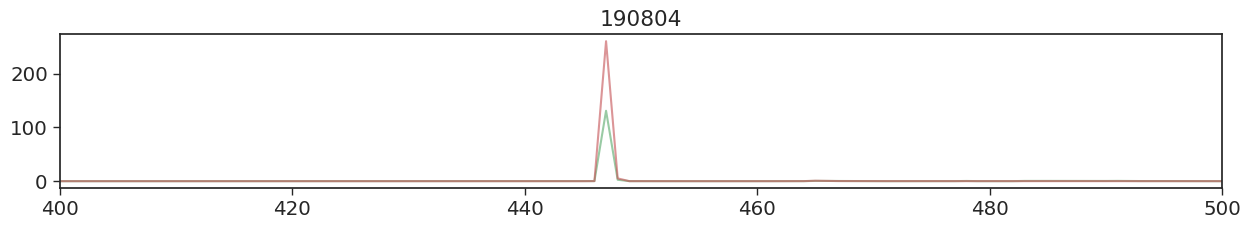

In [80]:
for i in range(x.shape[0]):
    plt.figure(figsize=[15,2])
    plt.plot(res['mean_control'][:,0], c='g', alpha=0.6)
    plt.plot(x[i], c='r', alpha=0.6)
    plt.xlim(400, 500)
    plt.title(cre_tiles_starts[i])
    plt.show()

In [56]:
res['mean_control'][:,0]

array([1.14167165e-02, 1.15655279e-02, 1.14901951e-02, 1.11881522e-02,
       1.19248237e-02, 1.18519906e-02, 1.05917426e-02, 1.08032543e-02,
       1.12483762e-02, 1.44365560e-02, 1.46113960e-02, 1.29723623e-02,
       9.21153836e-03, 3.02249528e-02, 1.04208766e-02, 8.82337615e-03,
       9.97960754e-03, 1.03140678e-02, 1.03564002e-02, 2.05481797e-02,
       1.09904343e-02, 1.55803654e-02, 1.67538039e-02, 1.80749334e-02,
       9.46766883e-03, 1.00069819e-02, 9.63087380e-03, 9.03656520e-03,
       1.39849875e-02, 9.84444376e-03, 1.18376436e-02, 1.01067750e-02,
       9.76482313e-03, 9.49927419e-03, 8.93709436e-03, 9.96689498e-03,
       1.09769953e-02, 1.14594866e-02, 9.10295732e-03, 9.55866929e-03,
       9.24384687e-03, 9.02142283e-03, 9.56560392e-03, 8.64158291e-03,
       9.82636772e-03, 1.03269126e-02, 1.07665649e-02, 1.00929076e-02,
       9.71780159e-03, 1.69473290e-02, 1.88856088e-02, 1.18500907e-02,
       1.03709744e-02, 1.13476906e-02, 8.89749266e-03, 9.96961631e-03,
      